# **Project SimCLR - CIFAR10**
### Import essential libraries and tools
Include Libraries

In [1]:
import os
import csv
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models.resnet import resnet50
from torchvision.datasets import CIFAR10

Essencial Gloabl Parameter

In [2]:
# Path for CIFAR10 data 
data_path = './data'

# Path for results
result_path = './result'
os.makedirs(result_path, exist_ok=True)

# Path for model/net storage
model_path = './models'
os.makedirs(model_path, exist_ok=True)

# Check device and apply the best hardware for Convolution computation
device = "cuda" if torch.cuda.is_available() else "CPU"
torch.backends.cudnn.benchmark = True if device == "cuda" else False

CIFAR10 Dataset

In [3]:
class CIFAR10_Dataset(CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            imgL = self.transform(img)
            imgR = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return imgL, imgR, target

Data Argumentation Transform

In [4]:
# Training set:
# 1. Crop || 2. Horizontal Flip || 3. Color Jitter || 4. Grayscale
# Apply normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# Training set:
# Only apply normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

### SimCLR Model

In [5]:
# Unsupervised Learning - SimCLR with encoder and projection head
class SimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()

        # Funtion F - Encoder
        # ResNet50 Implementation without linear and maxpool layer
        self.f = []
        for name, module in resnet50().named_children():
            # First Convolution layer changed to 3 channel input and 64 channel output to fit CIFAR10
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            # Drop all the final linear layer and max pool layer
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        self.f = nn.Sequential(*self.f)
        
        # Funtion G - Projection head
        # Two fully connected layer 
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))

    # F -> Flatten -> G
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)


# Supervised learning - Classifier with encoder and linear model
class Classifier(nn.Module):
    def __init__(self, num_class=10):
        super(Classifier, self).__init__()
        
        # Same function head - encoder
        self.f = SimCLR().f
        # FIX the encoder that does not update any parameter
        for param in self.f.parameters():
            param.requires_grad = False
        
        # Linear layer - classifier
        self.fc = nn.Linear(2048, num_class, bias=True)

    # F -> Flatten -> linear
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out

### Loss Function - NT-Xent loss

In [6]:
# NT-Xent Loss function implementation
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, out_1, out_2, batch_size, temperature=0.5):
        # Concatenated features - [2 * Batch size, feature dimension(128)] 
        out = torch.cat([out_1, out_2], dim=0)
        
        # Calculated similarity matrix - [2 * Batch size, 2 * Batch size]
        # The elements in the similarity matrix are normalized by dividing by the temperature parameter temperature
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        
        # Create a mask matrix - [2 * Batch size, 2 * Batch size]
        # The diagonal elements of the mask matrix are 0 and the other elements are 1 (diagonal element are similarity of itself)
        mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
        
        # Extract the valid elements in the similarity matrix (Denominator) - [2 * Batch size, 2 * Batch size - 1]
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

        # Compute numerator loss - [2 * Batch size]
        pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

        # Final loss - numerator / denominator
        return (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()

### Train SimCLR Model - Unsupervised Learning
As it is unsupervised learning, it do not need validation and test dataset

In [10]:
def train_SimCLR(batch_size, epochs, temperature=0.5):

    # Create model, loss, optimizer
    model = SimCLR().to(device)
    nt_xent_loss = Loss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    # Create training dataset
    train_dataset = CIFAR10_Dataset(root=data_path, train=True, transform=train_transform, download=True)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    # Check and create result saving file
    result_filename = 'SimCLR_B{}_E{}.csv'.format(batch_size, epochs)
    if not os.path.isfile(os.path.join(result_path, result_filename)):
        with open(os.path.join(result_path, result_filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Epoch", "Loss"])

    model.train()
    for epoch in range(1, epochs + 1):
        # Create loss and samples parameters
        total_loss, total_samples = 0, 0

        # Create a train bar for training visualization
        train_bar = tqdm(train_data)
        for imgL, imgR, labels in train_bar:
            # Transfer the image to the GPU
            imgL, imgR, labels = imgL.to(device), imgR.to(device), labels.to(device)

            # Apply SimCLR on two images
            feature_L, pre_L = model(imgL)
            feature_R, pre_R = model(imgR)

            # Claculating the NT Xent Loss
            loss = nt_xent_loss(pre_L, pre_R, batch_size, temperature)

            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print out loss
            total_samples += batch_size
            total_loss += loss.detach().item()
            train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_samples))

        # Calculate and print out epoch loss
        print("epoch loss:", total_loss / len(train_dataset) * batch_size)

        # write epoch loss to the result file
        with open(os.path.join(result_path, result_filename), "a") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, total_loss / len(train_dataset) * batch_size])

        # Save model with trained different epochs
        if epoch % 100 == 0:
            model_filename = 'SimCLR_B{}_E{}.pth'.format(batch_size, epoch)
            torch.save(model.state_dict(), os.path.join(model_path, model_filaname))

### Train Classifier Model - Supervised Learning

In [11]:
# train classifier
def train_Classfier(batch_size, model_name, epochs, ratio, lr=1e-3):
    
    # load dataset for train and eval
    train_dataset = CIFAR10(root=data_path, train=True, transform=train_transform, download=True)
    if ratio != 1:
        train_dataset, _ = random_split(train_dataset, [ratio, 1 - ratio])
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, persistent_workers=True)
    test_dataset = CIFAR10(root=data_path, train=False, transform=test_transform, download=True)
    test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=True)

    # Load model with function F, create loss, optimizer
    model = Classifier().to(device)
    model.load_state_dict(torch.load(os.path.join(model_path, model_name)), strict=False)
    loss_criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=1e-6)

    # Check and create result saving file
    result_filename = '{}_R{:.0f}_Classifier.csv'.format(model_name.split(".")[0], ratio * 100)
    if not os.path.isfile(os.path.join(result_path, result_filename)):
        with open(os.path.join(result_path, result_filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Epoch", "Loss", "Accuracy", "Top1 Acc", "Top5 Acc"])

    for epoch in range(1, epochs+1):
        # Training Classifier
        model.train()
        total_loss, total_samples, total_correct_samples = 0, 0, 0

        train_bar = tqdm(train_data)
        for data, target in train_bar:
            # Transfer model into GPU
            data, target = data.to(device), target.to(device)

            # Perform training, calculating loss
            predict = model(data)
            loss = loss_criterion(predict, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(predict.data, 1)
            total_correct_samples += (predicted == target).sum().item()

            total_loss += loss.item()
            total_samples += batch_size
            train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f} Acc: {:.4f}'.format(epoch, epochs,
                                      total_loss / total_samples, total_correct_samples / total_samples))

        # Calculate and print out epoch train loss
        train_loss = total_loss / len(train_dataset) * batch_size
        train_acc = total_correct_samples / total_samples
        print("Epoch", epoch, "Loss:", train_loss, "Acc:", train_acc)

        # Save the model
        model_filename = '{}_R{:.0f}_Classifier_E{}.pth'.format(model_name.split(".")[0], ratio * 100, epochs)
        torch.save(model.state_dict(), os.path.join(model_path, model_filename))

        # Save model with trained different epochs
        if epoch % 50 == 0:
            model_filename = '{}_R{:.0f}_Classifier_E{}.pth'.format(model_name.split(".")[0], ratio * 100, epoch)
            torch.save(model.state_dict(), os.path.join(model_path, model_filename))

        # Test the model
        model.eval()
        with torch.no_grad():
            #print("batch", " " * 1, "top1 acc", " " * 1, "top5 acc")
            total_loss, total_correct_1, total_correct_5, total_num = 0.0, 0.0, 0.0, 0
            teat_bar = tqdm(test_data)
            for data, target in teat_bar:
                data, target = data.to(device), target.to(device)
                pred = model(data)

                total_num += data.size(0)
                prediction = torch.argsort(pred, dim=-1, descending=True)
                top1_acc = torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
                top5_acc = torch.sum((prediction[:, 0:5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
                total_correct_1 += top1_acc
                total_correct_5 += top5_acc

                #print("  {:02}  ".format(batch + 1), " {:02.3f}%  ".format(top1_acc / data.size(0) * 100),
                #      "{:02.3f}%  ".format(top5_acc / data.size(0) * 100))

            top1_total_acc = total_correct_1 / total_num * 100
            top5_total_acc = total_correct_5 / total_num * 100
            print("all eval dataset:", "top1 acc: {:02.3f}%".format(top1_total_acc),
                  "top5 acc:{:02.3f}%".format(top5_total_acc))

        # Save the result
        with open(os.path.join(result_path, result_filename), "a") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, train_acc, top1_total_acc, top5_total_acc])

In [12]:
train_SimCLR(batch_size=64, epochs=500)

Files already downloaded and verified


  0%|                                                                                          | 0/781 [00:00<?, ?it/s]

tensor(4.8403, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0756:   0%|                                               | 1/781 [00:01<15:45,  1.21s/it]

tensor(4.8551, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0757:   0%|                                               | 2/781 [00:01<10:53,  1.19it/s]

tensor(4.8845, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0759:   0%|▏                                              | 3/781 [00:02<09:26,  1.37it/s]

tensor(4.8164, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0757:   1%|▏                                              | 4/781 [00:03<09:01,  1.44it/s]

tensor(4.8380, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0757:   1%|▎                                              | 5/781 [00:03<08:59,  1.44it/s]

tensor(4.8437, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0757:   1%|▎                                              | 6/781 [00:04<08:52,  1.45it/s]

tensor(4.8090, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0756:   1%|▍                                              | 7/781 [00:05<09:07,  1.41it/s]

tensor(4.8102, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0756:   1%|▍                                              | 8/781 [00:05<08:51,  1.46it/s]

tensor(4.7960, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0755:   1%|▌                                              | 9/781 [00:06<09:11,  1.40it/s]

tensor(4.8179, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0755:   1%|▌                                             | 10/781 [00:07<08:45,  1.47it/s]

tensor(4.8137, device='cuda:0', grad_fn=<MeanBackward0>)


Train Epoch: [1/500] Loss: 0.0755:   1%|▌                                             | 10/781 [00:07<10:10,  1.26it/s]


KeyboardInterrupt: 

In [ ]:
train_Classfier(batch_size=256, model_name='SimCLR_B256_E300.pth', epochs=200, ratio=1)

for ratio in [0.01, 0.1, 0.5, 1]:
    train_Classfier(batch_size=256, model_name='SimCLR_B256_E400.pth', epochs=200, ratio=ratio)

Files already downloaded and verified
Files already downloaded and verified


Train Epoch: [1/200] Loss: 0.0089 Acc: 0.2051: 100%|█████████████████████████████████████| 2/2 [00:26<00:00, 13.16s/it]


Epoch 1 Loss: 2.3386998291015626 Acc: 0.205078125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.05it/s]


all eval dataset: top1 acc: 41.710% top5 acc:83.290%


Train Epoch: [2/200] Loss: 0.0086 Acc: 0.4785: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  2.30it/s]


Epoch 2 Loss: 2.2563961181640626 Acc: 0.478515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.24it/s]


all eval dataset: top1 acc: 61.750% top5 acc:89.120%


Train Epoch: [3/200] Loss: 0.0083 Acc: 0.6348: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Epoch 3 Loss: 2.1764600830078127 Acc: 0.634765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.27it/s]


all eval dataset: top1 acc: 68.310% top5 acc:91.990%


Train Epoch: [4/200] Loss: 0.0080 Acc: 0.6953: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 4 Loss: 2.1042615966796876 Acc: 0.6953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.34it/s]


all eval dataset: top1 acc: 70.620% top5 acc:93.650%


Train Epoch: [5/200] Loss: 0.0078 Acc: 0.6934: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.35it/s]


Epoch 5 Loss: 2.0351004638671877 Acc: 0.693359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.27it/s]


all eval dataset: top1 acc: 72.210% top5 acc:94.700%


Train Epoch: [6/200] Loss: 0.0075 Acc: 0.7324: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.74it/s]


Epoch 6 Loss: 1.9540466918945312 Acc: 0.732421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.30it/s]


all eval dataset: top1 acc: 73.460% top5 acc:95.070%


Train Epoch: [7/200] Loss: 0.0073 Acc: 0.7285: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch 7 Loss: 1.903066162109375 Acc: 0.728515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.24it/s]


all eval dataset: top1 acc: 74.570% top5 acc:95.580%


Train Epoch: [8/200] Loss: 0.0070 Acc: 0.7422: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch 8 Loss: 1.8300372314453126 Acc: 0.7421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.27it/s]


all eval dataset: top1 acc: 75.380% top5 acc:95.960%


Train Epoch: [9/200] Loss: 0.0068 Acc: 0.7500: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  3.79it/s]


Epoch 9 Loss: 1.7804898071289061 Acc: 0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.26it/s]


all eval dataset: top1 acc: 75.850% top5 acc:96.210%


Train Epoch: [10/200] Loss: 0.0065 Acc: 0.7480: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch 10 Loss: 1.7073370361328124 Acc: 0.748046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.23it/s]


all eval dataset: top1 acc: 76.450% top5 acc:96.510%


Train Epoch: [11/200] Loss: 0.0063 Acc: 0.7871: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch 11 Loss: 1.6408463745117188 Acc: 0.787109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.29it/s]


all eval dataset: top1 acc: 77.020% top5 acc:96.820%


Train Epoch: [12/200] Loss: 0.0060 Acc: 0.7891: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch 12 Loss: 1.577556396484375 Acc: 0.7890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.25it/s]


all eval dataset: top1 acc: 77.490% top5 acc:97.130%


Train Epoch: [13/200] Loss: 0.0058 Acc: 0.7754: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.36it/s]


Epoch 13 Loss: 1.5294744262695312 Acc: 0.775390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.15it/s]


all eval dataset: top1 acc: 77.820% top5 acc:97.370%


Train Epoch: [14/200] Loss: 0.0056 Acc: 0.8086: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Epoch 14 Loss: 1.4688344116210938 Acc: 0.80859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.17it/s]


all eval dataset: top1 acc: 78.390% top5 acc:97.590%


Train Epoch: [15/200] Loss: 0.0054 Acc: 0.8223: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch 15 Loss: 1.422988037109375 Acc: 0.822265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.35it/s]


all eval dataset: top1 acc: 78.630% top5 acc:97.740%


Train Epoch: [16/200] Loss: 0.0053 Acc: 0.7910: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch 16 Loss: 1.3765660400390625 Acc: 0.791015625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.40it/s]


all eval dataset: top1 acc: 78.930% top5 acc:97.870%


Train Epoch: [17/200] Loss: 0.0051 Acc: 0.7930: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.38it/s]


Epoch 17 Loss: 1.3404326171875 Acc: 0.79296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.37it/s]


all eval dataset: top1 acc: 79.110% top5 acc:97.930%


Train Epoch: [18/200] Loss: 0.0050 Acc: 0.7852: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 18 Loss: 1.3025922241210937 Acc: 0.78515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.31it/s]


all eval dataset: top1 acc: 79.360% top5 acc:98.030%


Train Epoch: [19/200] Loss: 0.0048 Acc: 0.8086: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 19 Loss: 1.2705672607421874 Acc: 0.80859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.32it/s]


all eval dataset: top1 acc: 79.570% top5 acc:98.080%


Train Epoch: [20/200] Loss: 0.0047 Acc: 0.8359: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 20 Loss: 1.22751953125 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.19it/s]


all eval dataset: top1 acc: 79.760% top5 acc:98.190%


Train Epoch: [21/200] Loss: 0.0047 Acc: 0.7793: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 21 Loss: 1.2205159912109376 Acc: 0.779296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.03it/s]


all eval dataset: top1 acc: 79.850% top5 acc:98.220%


Train Epoch: [22/200] Loss: 0.0045 Acc: 0.8047: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 22 Loss: 1.174545654296875 Acc: 0.8046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.00it/s]


all eval dataset: top1 acc: 79.970% top5 acc:98.270%


Train Epoch: [23/200] Loss: 0.0043 Acc: 0.8047: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch 23 Loss: 1.133599853515625 Acc: 0.8046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 80.150% top5 acc:98.330%


Train Epoch: [24/200] Loss: 0.0041 Acc: 0.8359: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch 24 Loss: 1.0719109497070312 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 80.230% top5 acc:98.380%


Train Epoch: [25/200] Loss: 0.0040 Acc: 0.8047: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 25 Loss: 1.05933935546875 Acc: 0.8046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 80.320% top5 acc:98.440%


Train Epoch: [26/200] Loss: 0.0040 Acc: 0.8086: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 26 Loss: 1.0399984741210937 Acc: 0.80859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.75it/s]


all eval dataset: top1 acc: 80.460% top5 acc:98.420%


Train Epoch: [27/200] Loss: 0.0039 Acc: 0.8086: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 27 Loss: 1.0250830078125 Acc: 0.80859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 80.500% top5 acc:98.450%


Train Epoch: [28/200] Loss: 0.0038 Acc: 0.8105: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.32it/s]


Epoch 28 Loss: 1.0026400756835938 Acc: 0.810546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.23it/s]


all eval dataset: top1 acc: 80.550% top5 acc:98.490%


Train Epoch: [29/200] Loss: 0.0037 Acc: 0.8105: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 29 Loss: 0.962712890625 Acc: 0.810546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.24it/s]


all eval dataset: top1 acc: 80.670% top5 acc:98.500%


Train Epoch: [30/200] Loss: 0.0036 Acc: 0.8223: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]


Epoch 30 Loss: 0.9328015747070313 Acc: 0.822265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.22it/s]


all eval dataset: top1 acc: 80.890% top5 acc:98.500%


Train Epoch: [31/200] Loss: 0.0034 Acc: 0.8223: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 31 Loss: 0.9007755737304688 Acc: 0.822265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 80.990% top5 acc:98.530%


Train Epoch: [32/200] Loss: 0.0035 Acc: 0.8066: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 32 Loss: 0.9180528259277344 Acc: 0.806640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.98it/s]


all eval dataset: top1 acc: 81.240% top5 acc:98.550%


Train Epoch: [33/200] Loss: 0.0034 Acc: 0.8145: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.31it/s]


Epoch 33 Loss: 0.8944900207519532 Acc: 0.814453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.28it/s]


all eval dataset: top1 acc: 81.350% top5 acc:98.540%


Train Epoch: [34/200] Loss: 0.0033 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 34 Loss: 0.8566042785644531 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.87it/s]


all eval dataset: top1 acc: 81.460% top5 acc:98.570%


Train Epoch: [35/200] Loss: 0.0032 Acc: 0.8242: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


Epoch 35 Loss: 0.84521923828125 Acc: 0.82421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 81.490% top5 acc:98.570%


Train Epoch: [36/200] Loss: 0.0032 Acc: 0.8145: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 36 Loss: 0.8505598754882813 Acc: 0.814453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 81.520% top5 acc:98.600%


Train Epoch: [37/200] Loss: 0.0033 Acc: 0.8086: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 37 Loss: 0.8731424865722657 Acc: 0.80859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 81.630% top5 acc:98.630%


Train Epoch: [38/200] Loss: 0.0030 Acc: 0.8340: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch 38 Loss: 0.7892240905761718 Acc: 0.833984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 81.620% top5 acc:98.640%


Train Epoch: [39/200] Loss: 0.0030 Acc: 0.8320: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch 39 Loss: 0.7850912475585937 Acc: 0.83203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 81.640% top5 acc:98.650%


Train Epoch: [40/200] Loss: 0.0031 Acc: 0.8262: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 40 Loss: 0.8000038452148438 Acc: 0.826171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 81.670% top5 acc:98.640%


Train Epoch: [41/200] Loss: 0.0029 Acc: 0.8418: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 41 Loss: 0.7646636352539062 Acc: 0.841796875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 81.760% top5 acc:98.640%


Train Epoch: [42/200] Loss: 0.0030 Acc: 0.8105: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 42 Loss: 0.7909368591308594 Acc: 0.810546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 81.790% top5 acc:98.650%


Train Epoch: [43/200] Loss: 0.0030 Acc: 0.8203: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]


Epoch 43 Loss: 0.7927767639160156 Acc: 0.8203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 81.900% top5 acc:98.630%


Train Epoch: [44/200] Loss: 0.0029 Acc: 0.7910: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


Epoch 44 Loss: 0.7727162780761718 Acc: 0.791015625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s]


all eval dataset: top1 acc: 82.010% top5 acc:98.630%


Train Epoch: [45/200] Loss: 0.0027 Acc: 0.8262: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 45 Loss: 0.7180924377441407 Acc: 0.826171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 82.100% top5 acc:98.620%


Train Epoch: [46/200] Loss: 0.0028 Acc: 0.8379: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 46 Loss: 0.7219295654296874 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 82.110% top5 acc:98.670%


Train Epoch: [47/200] Loss: 0.0027 Acc: 0.8242: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.60it/s]


Epoch 47 Loss: 0.7089320983886719 Acc: 0.82421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 82.110% top5 acc:98.660%


Train Epoch: [48/200] Loss: 0.0028 Acc: 0.8340: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 48 Loss: 0.7242349853515625 Acc: 0.833984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 82.120% top5 acc:98.680%


Train Epoch: [49/200] Loss: 0.0027 Acc: 0.8379: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch 49 Loss: 0.6978026428222657 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 82.170% top5 acc:98.690%


Train Epoch: [50/200] Loss: 0.0027 Acc: 0.8105: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]


Epoch 50 Loss: 0.7141983642578125 Acc: 0.810546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 82.200% top5 acc:98.740%


Train Epoch: [51/200] Loss: 0.0027 Acc: 0.8184: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 51 Loss: 0.7032877197265625 Acc: 0.818359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 82.420% top5 acc:98.750%


Train Epoch: [52/200] Loss: 0.0026 Acc: 0.8281: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 52 Loss: 0.6897242431640624 Acc: 0.828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 82.430% top5 acc:98.740%


Train Epoch: [53/200] Loss: 0.0025 Acc: 0.8398: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 53 Loss: 0.6681951904296874 Acc: 0.83984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 82.440% top5 acc:98.720%


Train Epoch: [54/200] Loss: 0.0025 Acc: 0.8418: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 54 Loss: 0.6578565979003906 Acc: 0.841796875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 82.470% top5 acc:98.750%


Train Epoch: [55/200] Loss: 0.0024 Acc: 0.8359: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 55 Loss: 0.6415037841796875 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 82.550% top5 acc:98.740%


Train Epoch: [56/200] Loss: 0.0025 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 56 Loss: 0.6548979797363281 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 82.610% top5 acc:98.710%


Train Epoch: [57/200] Loss: 0.0024 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 57 Loss: 0.6278406372070312 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 82.620% top5 acc:98.700%


Train Epoch: [58/200] Loss: 0.0025 Acc: 0.8320: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch 58 Loss: 0.66693701171875 Acc: 0.83203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 82.670% top5 acc:98.690%


Train Epoch: [59/200] Loss: 0.0025 Acc: 0.8223: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 59 Loss: 0.6610327758789063 Acc: 0.822265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 82.610% top5 acc:98.720%


Train Epoch: [60/200] Loss: 0.0023 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]


Epoch 60 Loss: 0.6122693176269531 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 82.650% top5 acc:98.710%


Train Epoch: [61/200] Loss: 0.0024 Acc: 0.8652: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch 61 Loss: 0.6249065551757812 Acc: 0.865234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 82.660% top5 acc:98.760%


Train Epoch: [62/200] Loss: 0.0024 Acc: 0.8359: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 62 Loss: 0.6405012512207031 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 82.740% top5 acc:98.750%


Train Epoch: [63/200] Loss: 0.0024 Acc: 0.8340: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 63 Loss: 0.6245208129882812 Acc: 0.833984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 82.860% top5 acc:98.770%


Train Epoch: [64/200] Loss: 0.0023 Acc: 0.8418: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 64 Loss: 0.6007117614746094 Acc: 0.841796875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 82.890% top5 acc:98.780%


Train Epoch: [65/200] Loss: 0.0024 Acc: 0.8398: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 65 Loss: 0.6166321105957031 Acc: 0.83984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 82.880% top5 acc:98.800%


Train Epoch: [66/200] Loss: 0.0022 Acc: 0.8477: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 66 Loss: 0.585205322265625 Acc: 0.84765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 82.960% top5 acc:98.780%


Train Epoch: [67/200] Loss: 0.0024 Acc: 0.8301: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch 67 Loss: 0.6196580810546874 Acc: 0.830078125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 82.980% top5 acc:98.800%


Train Epoch: [68/200] Loss: 0.0021 Acc: 0.8652: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch 68 Loss: 0.5631258239746094 Acc: 0.865234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.010% top5 acc:98.810%


Train Epoch: [69/200] Loss: 0.0021 Acc: 0.8613: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 69 Loss: 0.5479543151855468 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.010% top5 acc:98.800%


Train Epoch: [70/200] Loss: 0.0021 Acc: 0.8594: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 70 Loss: 0.5556530456542969 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.060% top5 acc:98.800%


Train Epoch: [71/200] Loss: 0.0023 Acc: 0.8320: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]


Epoch 71 Loss: 0.5907227478027344 Acc: 0.83203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.110% top5 acc:98.820%


Train Epoch: [72/200] Loss: 0.0022 Acc: 0.8535: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch 72 Loss: 0.56938134765625 Acc: 0.853515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 83.090% top5 acc:98.850%


Train Epoch: [73/200] Loss: 0.0022 Acc: 0.8555: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 73 Loss: 0.5828183288574219 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.090% top5 acc:98.850%


Train Epoch: [74/200] Loss: 0.0022 Acc: 0.8477: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch 74 Loss: 0.5715125732421875 Acc: 0.84765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.070% top5 acc:98.840%


Train Epoch: [75/200] Loss: 0.0021 Acc: 0.8555: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 75 Loss: 0.5622097473144532 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.050% top5 acc:98.850%


Train Epoch: [76/200] Loss: 0.0022 Acc: 0.8555: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 76 Loss: 0.5729356994628906 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 83.040% top5 acc:98.850%


Train Epoch: [77/200] Loss: 0.0021 Acc: 0.8398: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 77 Loss: 0.5588481140136718 Acc: 0.83984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.110% top5 acc:98.870%


Train Epoch: [78/200] Loss: 0.0021 Acc: 0.8379: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 78 Loss: 0.5404994201660156 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s]


all eval dataset: top1 acc: 83.090% top5 acc:98.880%


Train Epoch: [79/200] Loss: 0.0020 Acc: 0.8496: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch 79 Loss: 0.5328512573242188 Acc: 0.849609375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 83.080% top5 acc:98.890%


Train Epoch: [80/200] Loss: 0.0021 Acc: 0.8379: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 80 Loss: 0.5437832336425781 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.160% top5 acc:98.890%


Train Epoch: [81/200] Loss: 0.0020 Acc: 0.8535: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 81 Loss: 0.5349746704101562 Acc: 0.853515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 83.140% top5 acc:98.890%


Train Epoch: [82/200] Loss: 0.0021 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 82 Loss: 0.5378335571289062 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.180% top5 acc:98.890%


Train Epoch: [83/200] Loss: 0.0020 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 83 Loss: 0.5232300109863282 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 83.170% top5 acc:98.910%


Train Epoch: [84/200] Loss: 0.0021 Acc: 0.8359: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 84 Loss: 0.5625859375 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 83.290% top5 acc:98.900%


Train Epoch: [85/200] Loss: 0.0020 Acc: 0.8652: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 85 Loss: 0.5333746337890625 Acc: 0.865234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.280% top5 acc:98.890%


Train Epoch: [86/200] Loss: 0.0019 Acc: 0.8633: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 86 Loss: 0.49938720703125 Acc: 0.86328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.370% top5 acc:98.900%


Train Epoch: [87/200] Loss: 0.0020 Acc: 0.8340: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch 87 Loss: 0.527665771484375 Acc: 0.833984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 83.460% top5 acc:98.890%


Train Epoch: [88/200] Loss: 0.0020 Acc: 0.8496: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 88 Loss: 0.5241921997070312 Acc: 0.849609375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.590% top5 acc:98.870%


Train Epoch: [89/200] Loss: 0.0020 Acc: 0.8633: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]


Epoch 89 Loss: 0.5343064270019531 Acc: 0.86328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.610% top5 acc:98.870%


Train Epoch: [90/200] Loss: 0.0020 Acc: 0.8613: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 90 Loss: 0.5264472961425781 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.660% top5 acc:98.880%


Train Epoch: [91/200] Loss: 0.0019 Acc: 0.8555: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 91 Loss: 0.49703253173828127 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 83.690% top5 acc:98.870%


Train Epoch: [92/200] Loss: 0.0021 Acc: 0.8281: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch 92 Loss: 0.5597155151367188 Acc: 0.828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 83.840% top5 acc:98.870%


Train Epoch: [93/200] Loss: 0.0018 Acc: 0.8574: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 93 Loss: 0.46359954833984374 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 83.800% top5 acc:98.880%


Train Epoch: [94/200] Loss: 0.0019 Acc: 0.8535: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


Epoch 94 Loss: 0.48564337158203125 Acc: 0.853515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 83.730% top5 acc:98.910%


Train Epoch: [95/200] Loss: 0.0019 Acc: 0.8418: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]


Epoch 95 Loss: 0.4996071319580078 Acc: 0.841796875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 83.780% top5 acc:98.910%


Train Epoch: [96/200] Loss: 0.0018 Acc: 0.8555: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch 96 Loss: 0.47566593933105467 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 83.720% top5 acc:98.930%


Train Epoch: [97/200] Loss: 0.0019 Acc: 0.8438: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 97 Loss: 0.5006662292480468 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.740% top5 acc:98.900%


Train Epoch: [98/200] Loss: 0.0018 Acc: 0.8555: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 98 Loss: 0.4803360137939453 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 83.710% top5 acc:98.910%


Train Epoch: [99/200] Loss: 0.0019 Acc: 0.8516: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


Epoch 99 Loss: 0.4881673583984375 Acc: 0.8515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 83.730% top5 acc:98.860%


Train Epoch: [100/200] Loss: 0.0019 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 100 Loss: 0.4867655639648438 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.750% top5 acc:98.870%


Train Epoch: [101/200] Loss: 0.0019 Acc: 0.8457: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch 101 Loss: 0.49300556945800783 Acc: 0.845703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 83.680% top5 acc:98.870%


Train Epoch: [102/200] Loss: 0.0020 Acc: 0.8418: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 102 Loss: 0.5168675537109375 Acc: 0.841796875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 83.700% top5 acc:98.870%


Train Epoch: [103/200] Loss: 0.0019 Acc: 0.8457: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 103 Loss: 0.5041591491699219 Acc: 0.845703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.710% top5 acc:98.870%


Train Epoch: [104/200] Loss: 0.0020 Acc: 0.8535: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 104 Loss: 0.5137961273193359 Acc: 0.853515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 83.730% top5 acc:98.860%


Train Epoch: [105/200] Loss: 0.0019 Acc: 0.8438: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 105 Loss: 0.48905224609375 Acc: 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.670% top5 acc:98.860%


Train Epoch: [106/200] Loss: 0.0018 Acc: 0.8574: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 106 Loss: 0.46523797607421874 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 83.790% top5 acc:98.880%


Train Epoch: [107/200] Loss: 0.0018 Acc: 0.8691: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 107 Loss: 0.46306605529785155 Acc: 0.869140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.810% top5 acc:98.900%


Train Epoch: [108/200] Loss: 0.0019 Acc: 0.8574: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 108 Loss: 0.4942183380126953 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.810% top5 acc:98.900%


Train Epoch: [109/200] Loss: 0.0019 Acc: 0.8574: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 109 Loss: 0.4972256622314453 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 83.820% top5 acc:98.900%


Train Epoch: [110/200] Loss: 0.0018 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch 110 Loss: 0.4747251434326172 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 83.800% top5 acc:98.920%


Train Epoch: [111/200] Loss: 0.0017 Acc: 0.8770: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 111 Loss: 0.43790760803222656 Acc: 0.876953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 83.850% top5 acc:98.900%


Train Epoch: [112/200] Loss: 0.0019 Acc: 0.8496: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


Epoch 112 Loss: 0.498869873046875 Acc: 0.849609375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 83.860% top5 acc:98.910%


Train Epoch: [113/200] Loss: 0.0016 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 113 Loss: 0.42303359985351563 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.890% top5 acc:98.900%


Train Epoch: [114/200] Loss: 0.0017 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 114 Loss: 0.45188661193847657 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.890% top5 acc:98.930%


Train Epoch: [115/200] Loss: 0.0017 Acc: 0.8574: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 115 Loss: 0.43876902770996096 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.860% top5 acc:98.910%


Train Epoch: [116/200] Loss: 0.0018 Acc: 0.8555: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 116 Loss: 0.48087530517578125 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 83.920% top5 acc:98.910%


Train Epoch: [117/200] Loss: 0.0017 Acc: 0.8711: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 117 Loss: 0.4452607421875 Acc: 0.87109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 83.900% top5 acc:98.900%


Train Epoch: [118/200] Loss: 0.0018 Acc: 0.8516: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 118 Loss: 0.4684557189941406 Acc: 0.8515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 83.880% top5 acc:98.900%


Train Epoch: [119/200] Loss: 0.0017 Acc: 0.8691: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 119 Loss: 0.4377420196533203 Acc: 0.869140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s]


all eval dataset: top1 acc: 83.930% top5 acc:98.880%


Train Epoch: [120/200] Loss: 0.0016 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]


Epoch 120 Loss: 0.4257736511230469 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.890% top5 acc:98.890%


Train Epoch: [121/200] Loss: 0.0017 Acc: 0.8652: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


Epoch 121 Loss: 0.4579822692871094 Acc: 0.865234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.910% top5 acc:98.880%


Train Epoch: [122/200] Loss: 0.0016 Acc: 0.8887: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 122 Loss: 0.42683694458007815 Acc: 0.888671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.930% top5 acc:98.880%


Train Epoch: [123/200] Loss: 0.0018 Acc: 0.8555: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 123 Loss: 0.46313555908203125 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.870% top5 acc:98.880%


Train Epoch: [124/200] Loss: 0.0017 Acc: 0.8574: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 124 Loss: 0.43554139709472656 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s]


all eval dataset: top1 acc: 83.870% top5 acc:98.880%


Train Epoch: [125/200] Loss: 0.0018 Acc: 0.8457: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch 125 Loss: 0.46985545349121094 Acc: 0.845703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.880% top5 acc:98.880%


Train Epoch: [126/200] Loss: 0.0016 Acc: 0.8574: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 126 Loss: 0.4234942016601563 Acc: 0.857421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.870% top5 acc:98.880%


Train Epoch: [127/200] Loss: 0.0017 Acc: 0.8457: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch 127 Loss: 0.4437493896484375 Acc: 0.845703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 83.890% top5 acc:98.860%


Train Epoch: [128/200] Loss: 0.0017 Acc: 0.8633: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch 128 Loss: 0.4513772277832031 Acc: 0.86328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 83.960% top5 acc:98.890%


Train Epoch: [129/200] Loss: 0.0017 Acc: 0.8633: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch 129 Loss: 0.4578002166748047 Acc: 0.86328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.010% top5 acc:98.890%


Train Epoch: [130/200] Loss: 0.0017 Acc: 0.8535: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 130 Loss: 0.4397919158935547 Acc: 0.853515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 83.950% top5 acc:98.830%


Train Epoch: [131/200] Loss: 0.0016 Acc: 0.8672: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 131 Loss: 0.4227985534667969 Acc: 0.8671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 83.920% top5 acc:98.860%


Train Epoch: [132/200] Loss: 0.0018 Acc: 0.8398: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch 132 Loss: 0.4810911865234375 Acc: 0.83984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.070% top5 acc:98.870%


Train Epoch: [133/200] Loss: 0.0016 Acc: 0.8555: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch 133 Loss: 0.43147805786132815 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.080% top5 acc:98.870%


Train Epoch: [134/200] Loss: 0.0017 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 134 Loss: 0.43391722106933595 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 84.040% top5 acc:98.870%


Train Epoch: [135/200] Loss: 0.0017 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 135 Loss: 0.4419112701416016 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 84.080% top5 acc:98.890%


Train Epoch: [136/200] Loss: 0.0016 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 136 Loss: 0.4156757354736328 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 84.130% top5 acc:98.880%


Train Epoch: [137/200] Loss: 0.0015 Acc: 0.8691: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]


Epoch 137 Loss: 0.40044235229492187 Acc: 0.869140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.200% top5 acc:98.910%


Train Epoch: [138/200] Loss: 0.0017 Acc: 0.8555: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]


Epoch 138 Loss: 0.4498145294189453 Acc: 0.85546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 84.220% top5 acc:98.920%


Train Epoch: [139/200] Loss: 0.0017 Acc: 0.8516: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch 139 Loss: 0.43646310424804685 Acc: 0.8515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 84.140% top5 acc:98.930%


Train Epoch: [140/200] Loss: 0.0015 Acc: 0.8809: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 140 Loss: 0.3936049499511719 Acc: 0.880859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.140% top5 acc:98.940%


Train Epoch: [141/200] Loss: 0.0019 Acc: 0.8379: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 141 Loss: 0.4865880889892578 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.090% top5 acc:98.920%


Train Epoch: [142/200] Loss: 0.0016 Acc: 0.8672: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 142 Loss: 0.4199236907958984 Acc: 0.8671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.140% top5 acc:98.920%


Train Epoch: [143/200] Loss: 0.0016 Acc: 0.8633: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


Epoch 143 Loss: 0.41545419311523435 Acc: 0.86328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.140% top5 acc:98.920%


Train Epoch: [144/200] Loss: 0.0014 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 144 Loss: 0.36901686096191405 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 84.130% top5 acc:98.930%


Train Epoch: [145/200] Loss: 0.0016 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch 145 Loss: 0.4260125274658203 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.140% top5 acc:98.920%


Train Epoch: [146/200] Loss: 0.0017 Acc: 0.8379: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 146 Loss: 0.4347174377441406 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.160% top5 acc:98.910%


Train Epoch: [147/200] Loss: 0.0016 Acc: 0.8750: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]


Epoch 147 Loss: 0.43113394165039065 Acc: 0.875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.090% top5 acc:98.890%


Train Epoch: [148/200] Loss: 0.0016 Acc: 0.8633: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 148 Loss: 0.4235332336425781 Acc: 0.86328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.100% top5 acc:98.880%


Train Epoch: [149/200] Loss: 0.0017 Acc: 0.8477: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 149 Loss: 0.4434844207763672 Acc: 0.84765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.080% top5 acc:98.880%


Train Epoch: [150/200] Loss: 0.0016 Acc: 0.8672: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 150 Loss: 0.4192417755126953 Acc: 0.8671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.090% top5 acc:98.900%


Train Epoch: [151/200] Loss: 0.0015 Acc: 0.8711: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 151 Loss: 0.39913626098632815 Acc: 0.87109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.090% top5 acc:98.900%


Train Epoch: [152/200] Loss: 0.0016 Acc: 0.8730: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 152 Loss: 0.43072874450683596 Acc: 0.873046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.130% top5 acc:98.900%


Train Epoch: [153/200] Loss: 0.0018 Acc: 0.8340: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 153 Loss: 0.4685232391357422 Acc: 0.833984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.180% top5 acc:98.890%


Train Epoch: [154/200] Loss: 0.0016 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 154 Loss: 0.41511865234375 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.160% top5 acc:98.900%


Train Epoch: [155/200] Loss: 0.0013 Acc: 0.9062: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 155 Loss: 0.3505405426025391 Acc: 0.90625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 84.230% top5 acc:98.900%


Train Epoch: [156/200] Loss: 0.0017 Acc: 0.8711: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch 156 Loss: 0.43557362365722657 Acc: 0.87109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.310% top5 acc:98.890%


Train Epoch: [157/200] Loss: 0.0015 Acc: 0.8730: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 157 Loss: 0.40130972290039063 Acc: 0.873046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 84.240% top5 acc:98.870%


Train Epoch: [158/200] Loss: 0.0017 Acc: 0.8496: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]


Epoch 158 Loss: 0.4534877166748047 Acc: 0.849609375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.310% top5 acc:98.890%


Train Epoch: [159/200] Loss: 0.0014 Acc: 0.8867: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 159 Loss: 0.3780513763427734 Acc: 0.88671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.280% top5 acc:98.890%


Train Epoch: [160/200] Loss: 0.0016 Acc: 0.8672: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch 160 Loss: 0.41333363342285157 Acc: 0.8671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.390% top5 acc:98.880%


Train Epoch: [161/200] Loss: 0.0016 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch 161 Loss: 0.4148990020751953 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.380% top5 acc:98.880%


Train Epoch: [162/200] Loss: 0.0015 Acc: 0.8789: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch 162 Loss: 0.38156288146972656 Acc: 0.87890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 84.330% top5 acc:98.910%


Train Epoch: [163/200] Loss: 0.0015 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 163 Loss: 0.3807088928222656 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.320% top5 acc:98.900%


Train Epoch: [164/200] Loss: 0.0016 Acc: 0.8613: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 164 Loss: 0.42859347534179687 Acc: 0.861328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 84.290% top5 acc:98.900%


Train Epoch: [165/200] Loss: 0.0015 Acc: 0.8789: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch 165 Loss: 0.39409222412109374 Acc: 0.87890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 84.300% top5 acc:98.900%


Train Epoch: [166/200] Loss: 0.0016 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 166 Loss: 0.427184326171875 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.380% top5 acc:98.890%


Train Epoch: [167/200] Loss: 0.0015 Acc: 0.8652: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 167 Loss: 0.3937783966064453 Acc: 0.865234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.310% top5 acc:98.890%


Train Epoch: [168/200] Loss: 0.0017 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 168 Loss: 0.43432164001464846 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.290% top5 acc:98.910%


Train Epoch: [169/200] Loss: 0.0013 Acc: 0.8965: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch 169 Loss: 0.3533084259033203 Acc: 0.896484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.350% top5 acc:98.910%


Train Epoch: [170/200] Loss: 0.0014 Acc: 0.8867: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 170 Loss: 0.3677173309326172 Acc: 0.88671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 84.290% top5 acc:98.910%


Train Epoch: [171/200] Loss: 0.0014 Acc: 0.8789: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 171 Loss: 0.37577667236328127 Acc: 0.87890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.310% top5 acc:98.890%


Train Epoch: [172/200] Loss: 0.0016 Acc: 0.8672: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 172 Loss: 0.4236756591796875 Acc: 0.8671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.270% top5 acc:98.920%


Train Epoch: [173/200] Loss: 0.0016 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]


Epoch 173 Loss: 0.41595025634765626 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.260% top5 acc:98.920%


Train Epoch: [174/200] Loss: 0.0016 Acc: 0.8691: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.28it/s]


Epoch 174 Loss: 0.41082861328125 Acc: 0.869140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.250% top5 acc:98.910%


Train Epoch: [175/200] Loss: 0.0014 Acc: 0.8770: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 175 Loss: 0.36402708435058595 Acc: 0.876953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.260% top5 acc:98.910%


Train Epoch: [176/200] Loss: 0.0014 Acc: 0.8965: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 176 Loss: 0.357468994140625 Acc: 0.896484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.270% top5 acc:98.910%


Train Epoch: [177/200] Loss: 0.0016 Acc: 0.8711: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


Epoch 177 Loss: 0.41514498901367186 Acc: 0.87109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.250% top5 acc:98.890%


Train Epoch: [178/200] Loss: 0.0015 Acc: 0.8789: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 178 Loss: 0.39679220581054686 Acc: 0.87890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.69it/s]


all eval dataset: top1 acc: 84.310% top5 acc:98.900%


Train Epoch: [179/200] Loss: 0.0013 Acc: 0.9004: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]


Epoch 179 Loss: 0.3432471466064453 Acc: 0.900390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 84.320% top5 acc:98.900%


Train Epoch: [180/200] Loss: 0.0014 Acc: 0.8945: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch 180 Loss: 0.3664689636230469 Acc: 0.89453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.350% top5 acc:98.900%


Train Epoch: [181/200] Loss: 0.0015 Acc: 0.8672: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch 181 Loss: 0.3976034393310547 Acc: 0.8671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 84.420% top5 acc:98.890%


Train Epoch: [182/200] Loss: 0.0014 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 182 Loss: 0.37758961486816406 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.410% top5 acc:98.910%


Train Epoch: [183/200] Loss: 0.0015 Acc: 0.8770: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 183 Loss: 0.39045481872558596 Acc: 0.876953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 84.420% top5 acc:98.890%


Train Epoch: [184/200] Loss: 0.0015 Acc: 0.8594: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch 184 Loss: 0.38761123657226565 Acc: 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.430% top5 acc:98.900%


Train Epoch: [185/200] Loss: 0.0013 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]


Epoch 185 Loss: 0.3361577606201172 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.390% top5 acc:98.920%


Train Epoch: [186/200] Loss: 0.0012 Acc: 0.9043: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 186 Loss: 0.32126937866210936 Acc: 0.904296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.370% top5 acc:98.910%


Train Epoch: [187/200] Loss: 0.0013 Acc: 0.8867: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 187 Loss: 0.3456852722167969 Acc: 0.88671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 84.400% top5 acc:98.910%


Train Epoch: [188/200] Loss: 0.0014 Acc: 0.8867: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 188 Loss: 0.3559318237304688 Acc: 0.88671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 84.430% top5 acc:98.910%


Train Epoch: [189/200] Loss: 0.0014 Acc: 0.8789: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 189 Loss: 0.3722723083496094 Acc: 0.87890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.420% top5 acc:98.920%


Train Epoch: [190/200] Loss: 0.0013 Acc: 0.8926: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 190 Loss: 0.3490434265136719 Acc: 0.892578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 84.420% top5 acc:98.920%


Train Epoch: [191/200] Loss: 0.0014 Acc: 0.8984: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 191 Loss: 0.35532939147949216 Acc: 0.8984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.440% top5 acc:98.940%


Train Epoch: [192/200] Loss: 0.0012 Acc: 0.8965: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch 192 Loss: 0.3213177642822266 Acc: 0.896484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.450% top5 acc:98.930%


Train Epoch: [193/200] Loss: 0.0014 Acc: 0.8828: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 193 Loss: 0.3563153076171875 Acc: 0.8828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.480% top5 acc:98.900%


Train Epoch: [194/200] Loss: 0.0015 Acc: 0.8730: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 194 Loss: 0.3890086669921875 Acc: 0.873046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 84.520% top5 acc:98.890%


Train Epoch: [195/200] Loss: 0.0013 Acc: 0.9004: 100%|███████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]


Epoch 195 Loss: 0.32810809326171875 Acc: 0.900390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 84.560% top5 acc:98.900%


Train Epoch: [196/200] Loss: 0.0013 Acc: 0.8848: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 196 Loss: 0.3530936889648438 Acc: 0.884765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 84.550% top5 acc:98.900%


Train Epoch: [197/200] Loss: 0.0015 Acc: 0.8711: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]


Epoch 197 Loss: 0.3881228332519531 Acc: 0.87109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.570% top5 acc:98.920%


Train Epoch: [198/200] Loss: 0.0014 Acc: 0.8711: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 198 Loss: 0.3693134002685547 Acc: 0.87109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.580% top5 acc:98.910%


Train Epoch: [199/200] Loss: 0.0013 Acc: 0.8945: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 199 Loss: 0.3416172180175781 Acc: 0.89453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 84.510% top5 acc:98.920%


Train Epoch: [200/200] Loss: 0.0012 Acc: 0.8926: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 200 Loss: 0.32027804565429685 Acc: 0.892578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 84.520% top5 acc:98.920%
Files already downloaded and verified
Files already downloaded and verified


Train Epoch: [1/200] Loss: 0.0078 Acc: 0.5928: 100%|███████████████████████████████████| 20/20 [00:33<00:00,  1.69s/it]


Epoch 1 Loss: 2.0438041442871095 Acc: 0.5927734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.08it/s]


all eval dataset: top1 acc: 79.600% top5 acc:98.810%


Train Epoch: [2/200] Loss: 0.0057 Acc: 0.7516: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 2 Loss: 1.501825067138672 Acc: 0.7515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 81.680% top5 acc:99.010%


Train Epoch: [3/200] Loss: 0.0044 Acc: 0.7645: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 3 Loss: 1.1583869567871095 Acc: 0.764453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 82.070% top5 acc:99.070%


Train Epoch: [4/200] Loss: 0.0037 Acc: 0.7631: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 4 Loss: 0.9776294006347657 Acc: 0.7630859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 82.780% top5 acc:99.120%


Train Epoch: [5/200] Loss: 0.0032 Acc: 0.7766: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 5 Loss: 0.8464872344970703 Acc: 0.7765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 83.510% top5 acc:99.250%


Train Epoch: [6/200] Loss: 0.0030 Acc: 0.7768: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 6 Loss: 0.7851873718261718 Acc: 0.7767578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 83.950% top5 acc:99.270%


Train Epoch: [7/200] Loss: 0.0028 Acc: 0.7838: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 7 Loss: 0.7402931915283203 Acc: 0.7837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.490% top5 acc:99.250%


Train Epoch: [8/200] Loss: 0.0027 Acc: 0.7766: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]


Epoch 8 Loss: 0.703228564453125 Acc: 0.7765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 84.620% top5 acc:99.360%


Train Epoch: [9/200] Loss: 0.0025 Acc: 0.7910: 100%|███████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 9 Loss: 0.662475146484375 Acc: 0.791015625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 84.910% top5 acc:99.360%


Train Epoch: [10/200] Loss: 0.0025 Acc: 0.7807: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 10 Loss: 0.6597713226318359 Acc: 0.7806640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.52it/s]


all eval dataset: top1 acc: 85.160% top5 acc:99.410%


Train Epoch: [11/200] Loss: 0.0024 Acc: 0.7838: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 11 Loss: 0.6358517791748047 Acc: 0.7837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 85.490% top5 acc:99.430%


Train Epoch: [12/200] Loss: 0.0023 Acc: 0.7947: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 12 Loss: 0.6076539199829102 Acc: 0.7947265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 85.660% top5 acc:99.450%


Train Epoch: [13/200] Loss: 0.0023 Acc: 0.7998: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 13 Loss: 0.5908550659179688 Acc: 0.7998046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 85.620% top5 acc:99.470%


Train Epoch: [14/200] Loss: 0.0023 Acc: 0.7914: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 14 Loss: 0.5995813674926758 Acc: 0.79140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 85.880% top5 acc:99.430%


Train Epoch: [15/200] Loss: 0.0022 Acc: 0.7949: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 15 Loss: 0.5803218231201172 Acc: 0.794921875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 85.950% top5 acc:99.430%


Train Epoch: [16/200] Loss: 0.0021 Acc: 0.8082: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 16 Loss: 0.559525732421875 Acc: 0.808203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 85.990% top5 acc:99.500%


Train Epoch: [17/200] Loss: 0.0022 Acc: 0.7980: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 17 Loss: 0.5656973159790039 Acc: 0.798046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 86.120% top5 acc:99.450%


Train Epoch: [18/200] Loss: 0.0022 Acc: 0.8018: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch 18 Loss: 0.571560595703125 Acc: 0.8017578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 86.160% top5 acc:99.530%


Train Epoch: [19/200] Loss: 0.0022 Acc: 0.7994: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 19 Loss: 0.5637204940795898 Acc: 0.7994140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 86.490% top5 acc:99.520%


Train Epoch: [20/200] Loss: 0.0021 Acc: 0.7955: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 20 Loss: 0.5469134384155273 Acc: 0.7955078125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 86.420% top5 acc:99.510%


Train Epoch: [21/200] Loss: 0.0021 Acc: 0.8021: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch 21 Loss: 0.5588020767211914 Acc: 0.8021484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 86.610% top5 acc:99.530%


Train Epoch: [22/200] Loss: 0.0021 Acc: 0.8012: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 22 Loss: 0.5451636779785156 Acc: 0.801171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 86.720% top5 acc:99.520%


Train Epoch: [23/200] Loss: 0.0021 Acc: 0.7945: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 23 Loss: 0.550132960510254 Acc: 0.79453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 86.940% top5 acc:99.510%


Train Epoch: [24/200] Loss: 0.0020 Acc: 0.8072: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 24 Loss: 0.5306890930175782 Acc: 0.8072265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 86.990% top5 acc:99.540%


Train Epoch: [25/200] Loss: 0.0020 Acc: 0.8035: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 25 Loss: 0.5317227340698242 Acc: 0.803515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 87.080% top5 acc:99.540%


Train Epoch: [26/200] Loss: 0.0020 Acc: 0.8043: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 26 Loss: 0.5369313140869141 Acc: 0.804296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 87.060% top5 acc:99.580%


Train Epoch: [27/200] Loss: 0.0021 Acc: 0.8004: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]


Epoch 27 Loss: 0.5415923034667969 Acc: 0.800390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.190% top5 acc:99.570%


Train Epoch: [28/200] Loss: 0.0020 Acc: 0.8109: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 28 Loss: 0.5212373321533204 Acc: 0.8109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 86.810% top5 acc:99.550%


Train Epoch: [29/200] Loss: 0.0020 Acc: 0.8016: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 29 Loss: 0.521783039855957 Acc: 0.8015625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 87.110% top5 acc:99.570%


Train Epoch: [30/200] Loss: 0.0020 Acc: 0.8109: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 30 Loss: 0.5168214340209961 Acc: 0.8109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 87.280% top5 acc:99.580%


Train Epoch: [31/200] Loss: 0.0020 Acc: 0.7994: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 31 Loss: 0.5344750198364258 Acc: 0.7994140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.310% top5 acc:99.590%


Train Epoch: [32/200] Loss: 0.0020 Acc: 0.8096: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 32 Loss: 0.523835986328125 Acc: 0.8095703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 87.150% top5 acc:99.610%


Train Epoch: [33/200] Loss: 0.0019 Acc: 0.8141: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch 33 Loss: 0.5070825210571289 Acc: 0.8140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 87.350% top5 acc:99.590%


Train Epoch: [34/200] Loss: 0.0019 Acc: 0.8174: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 34 Loss: 0.49818880767822266 Acc: 0.8173828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.420% top5 acc:99.600%


Train Epoch: [35/200] Loss: 0.0019 Acc: 0.8158: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 35 Loss: 0.49835145416259763 Acc: 0.8158203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.350% top5 acc:99.620%


Train Epoch: [36/200] Loss: 0.0019 Acc: 0.8131: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 36 Loss: 0.5081722488403321 Acc: 0.8130859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.480% top5 acc:99.630%


Train Epoch: [37/200] Loss: 0.0019 Acc: 0.8141: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 37 Loss: 0.49999086151123046 Acc: 0.8140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.470% top5 acc:99.610%


Train Epoch: [38/200] Loss: 0.0019 Acc: 0.8164: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 38 Loss: 0.48708675231933596 Acc: 0.81640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.350% top5 acc:99.630%


Train Epoch: [39/200] Loss: 0.0019 Acc: 0.8135: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 39 Loss: 0.4929981140136719 Acc: 0.8134765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.400% top5 acc:99.630%


Train Epoch: [40/200] Loss: 0.0020 Acc: 0.8076: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 40 Loss: 0.5121713897705078 Acc: 0.8076171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.570% top5 acc:99.670%


Train Epoch: [41/200] Loss: 0.0019 Acc: 0.8105: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 41 Loss: 0.502806283569336 Acc: 0.810546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.550% top5 acc:99.620%


Train Epoch: [42/200] Loss: 0.0019 Acc: 0.8109: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 42 Loss: 0.5056456680297852 Acc: 0.8109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.740% top5 acc:99.630%


Train Epoch: [43/200] Loss: 0.0019 Acc: 0.8117: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 43 Loss: 0.4850152221679688 Acc: 0.81171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 87.430% top5 acc:99.620%


Train Epoch: [44/200] Loss: 0.0019 Acc: 0.8205: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 44 Loss: 0.4877187255859375 Acc: 0.8205078125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 87.620% top5 acc:99.580%


Train Epoch: [45/200] Loss: 0.0019 Acc: 0.8154: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 45 Loss: 0.4951121017456055 Acc: 0.8154296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.610% top5 acc:99.620%


Train Epoch: [46/200] Loss: 0.0019 Acc: 0.8139: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 46 Loss: 0.48876493225097656 Acc: 0.8138671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 87.700% top5 acc:99.630%


Train Epoch: [47/200] Loss: 0.0018 Acc: 0.8187: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 47 Loss: 0.48311578216552736 Acc: 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s]


all eval dataset: top1 acc: 87.550% top5 acc:99.640%


Train Epoch: [48/200] Loss: 0.0019 Acc: 0.8146: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 48 Loss: 0.4898988357543945 Acc: 0.8146484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.680% top5 acc:99.650%


Train Epoch: [49/200] Loss: 0.0018 Acc: 0.8178: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 49 Loss: 0.48453175201416016 Acc: 0.8177734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 87.720% top5 acc:99.650%


Train Epoch: [50/200] Loss: 0.0019 Acc: 0.8199: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]


Epoch 50 Loss: 0.4860997940063477 Acc: 0.819921875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 87.690% top5 acc:99.640%


Train Epoch: [51/200] Loss: 0.0019 Acc: 0.8184: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 51 Loss: 0.4885799789428711 Acc: 0.818359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.700% top5 acc:99.640%


Train Epoch: [52/200] Loss: 0.0018 Acc: 0.8232: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 52 Loss: 0.4794136306762695 Acc: 0.8232421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s]


all eval dataset: top1 acc: 87.800% top5 acc:99.640%


Train Epoch: [53/200] Loss: 0.0018 Acc: 0.8195: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 53 Loss: 0.46919165344238284 Acc: 0.81953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 87.800% top5 acc:99.680%


Train Epoch: [54/200] Loss: 0.0017 Acc: 0.8227: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 54 Loss: 0.4585178207397461 Acc: 0.82265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 87.660% top5 acc:99.660%


Train Epoch: [55/200] Loss: 0.0018 Acc: 0.8219: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 55 Loss: 0.483598356628418 Acc: 0.821875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 87.660% top5 acc:99.650%


Train Epoch: [56/200] Loss: 0.0017 Acc: 0.8283: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 56 Loss: 0.45320537109375 Acc: 0.8283203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 87.720% top5 acc:99.630%


Train Epoch: [57/200] Loss: 0.0018 Acc: 0.8242: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 57 Loss: 0.4642924331665039 Acc: 0.82421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 87.720% top5 acc:99.620%


Train Epoch: [58/200] Loss: 0.0018 Acc: 0.8234: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 58 Loss: 0.4737384140014648 Acc: 0.8234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 87.960% top5 acc:99.660%


Train Epoch: [59/200] Loss: 0.0018 Acc: 0.8189: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]


Epoch 59 Loss: 0.47193514404296877 Acc: 0.8189453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.680% top5 acc:99.660%


Train Epoch: [60/200] Loss: 0.0018 Acc: 0.8271: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 60 Loss: 0.46791885528564453 Acc: 0.8271484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 87.820% top5 acc:99.640%


Train Epoch: [61/200] Loss: 0.0018 Acc: 0.8197: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 61 Loss: 0.47995449981689453 Acc: 0.8197265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.770% top5 acc:99.680%


Train Epoch: [62/200] Loss: 0.0018 Acc: 0.8215: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 62 Loss: 0.46897845306396485 Acc: 0.821484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 87.790% top5 acc:99.680%


Train Epoch: [63/200] Loss: 0.0018 Acc: 0.8184: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 63 Loss: 0.4640663833618164 Acc: 0.818359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.750% top5 acc:99.650%


Train Epoch: [64/200] Loss: 0.0018 Acc: 0.8240: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch 64 Loss: 0.4661548416137695 Acc: 0.8240234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.860% top5 acc:99.600%


Train Epoch: [65/200] Loss: 0.0017 Acc: 0.8262: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 65 Loss: 0.45727225341796873 Acc: 0.826171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.850% top5 acc:99.650%


Train Epoch: [66/200] Loss: 0.0017 Acc: 0.8266: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 66 Loss: 0.45862992095947264 Acc: 0.8265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.630% top5 acc:99.690%


Train Epoch: [67/200] Loss: 0.0018 Acc: 0.8234: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]


Epoch 67 Loss: 0.4605811996459961 Acc: 0.8234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.930% top5 acc:99.660%


Train Epoch: [68/200] Loss: 0.0018 Acc: 0.8146: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 68 Loss: 0.4768516540527344 Acc: 0.8146484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.980% top5 acc:99.630%


Train Epoch: [69/200] Loss: 0.0018 Acc: 0.8207: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 69 Loss: 0.45982203979492187 Acc: 0.820703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.730% top5 acc:99.630%


Train Epoch: [70/200] Loss: 0.0018 Acc: 0.8248: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 70 Loss: 0.46189633941650393 Acc: 0.8248046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.870% top5 acc:99.660%


Train Epoch: [71/200] Loss: 0.0017 Acc: 0.8305: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 71 Loss: 0.44307622833251953 Acc: 0.83046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 87.890% top5 acc:99.640%


Train Epoch: [72/200] Loss: 0.0017 Acc: 0.8258: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 72 Loss: 0.4499627685546875 Acc: 0.82578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.990% top5 acc:99.640%


Train Epoch: [73/200] Loss: 0.0018 Acc: 0.8264: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 73 Loss: 0.4651709213256836 Acc: 0.8263671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.900% top5 acc:99.650%


Train Epoch: [74/200] Loss: 0.0018 Acc: 0.8250: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 74 Loss: 0.4683528732299805 Acc: 0.825


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.910% top5 acc:99.650%


Train Epoch: [75/200] Loss: 0.0018 Acc: 0.8211: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 75 Loss: 0.4622364028930664 Acc: 0.82109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.030% top5 acc:99.660%


Train Epoch: [76/200] Loss: 0.0018 Acc: 0.8215: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 76 Loss: 0.4648447814941406 Acc: 0.821484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.980% top5 acc:99.600%


Train Epoch: [77/200] Loss: 0.0018 Acc: 0.8275: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 77 Loss: 0.4600997299194336 Acc: 0.8275390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 87.930% top5 acc:99.660%


Train Epoch: [78/200] Loss: 0.0018 Acc: 0.8150: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 78 Loss: 0.48244214782714845 Acc: 0.8150390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 87.990% top5 acc:99.650%


Train Epoch: [79/200] Loss: 0.0018 Acc: 0.8227: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 79 Loss: 0.4600079452514648 Acc: 0.82265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.890% top5 acc:99.610%


Train Epoch: [80/200] Loss: 0.0017 Acc: 0.8262: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 80 Loss: 0.4514276596069336 Acc: 0.826171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.960% top5 acc:99.670%


Train Epoch: [81/200] Loss: 0.0018 Acc: 0.8219: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 81 Loss: 0.45917487030029297 Acc: 0.821875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.090% top5 acc:99.610%


Train Epoch: [82/200] Loss: 0.0017 Acc: 0.8260: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 82 Loss: 0.45511047668457033 Acc: 0.8259765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.090% top5 acc:99.620%


Train Epoch: [83/200] Loss: 0.0016 Acc: 0.8285: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 83 Loss: 0.43232127075195315 Acc: 0.828515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.020% top5 acc:99.620%


Train Epoch: [84/200] Loss: 0.0018 Acc: 0.8232: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 84 Loss: 0.4627211669921875 Acc: 0.8232421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.010% top5 acc:99.640%


Train Epoch: [85/200] Loss: 0.0017 Acc: 0.8260: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 85 Loss: 0.4494751907348633 Acc: 0.8259765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 87.930% top5 acc:99.620%


Train Epoch: [86/200] Loss: 0.0017 Acc: 0.8311: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 86 Loss: 0.44656334381103513 Acc: 0.8310546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.090% top5 acc:99.640%


Train Epoch: [87/200] Loss: 0.0017 Acc: 0.8289: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 87 Loss: 0.44987445220947264 Acc: 0.82890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.940% top5 acc:99.610%


Train Epoch: [88/200] Loss: 0.0018 Acc: 0.8268: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 88 Loss: 0.4711560928344727 Acc: 0.8267578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 87.900% top5 acc:99.620%


Train Epoch: [89/200] Loss: 0.0017 Acc: 0.8234: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 89 Loss: 0.4416163787841797 Acc: 0.8234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 87.930% top5 acc:99.630%


Train Epoch: [90/200] Loss: 0.0018 Acc: 0.8262: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 90 Loss: 0.46136349182128905 Acc: 0.826171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.52it/s]


all eval dataset: top1 acc: 87.940% top5 acc:99.600%


Train Epoch: [91/200] Loss: 0.0017 Acc: 0.8307: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 91 Loss: 0.43749068298339844 Acc: 0.8306640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.050% top5 acc:99.650%


Train Epoch: [92/200] Loss: 0.0017 Acc: 0.8273: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


Epoch 92 Loss: 0.45865765686035154 Acc: 0.82734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.090% top5 acc:99.650%


Train Epoch: [93/200] Loss: 0.0017 Acc: 0.8371: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 93 Loss: 0.44256697692871094 Acc: 0.837109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.010% top5 acc:99.620%


Train Epoch: [94/200] Loss: 0.0017 Acc: 0.8283: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 94 Loss: 0.44626590576171876 Acc: 0.8283203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 87.980% top5 acc:99.620%


Train Epoch: [95/200] Loss: 0.0017 Acc: 0.8279: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 95 Loss: 0.45633615417480466 Acc: 0.8279296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.070% top5 acc:99.610%


Train Epoch: [96/200] Loss: 0.0018 Acc: 0.8268: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 96 Loss: 0.45940039825439455 Acc: 0.8267578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.000% top5 acc:99.630%


Train Epoch: [97/200] Loss: 0.0017 Acc: 0.8260: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 97 Loss: 0.45167420349121096 Acc: 0.8259765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.040% top5 acc:99.620%


Train Epoch: [98/200] Loss: 0.0016 Acc: 0.8395: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 98 Loss: 0.42404329528808593 Acc: 0.839453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 87.940% top5 acc:99.620%


Train Epoch: [99/200] Loss: 0.0017 Acc: 0.8330: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 99 Loss: 0.4338935455322266 Acc: 0.8330078125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 88.160% top5 acc:99.620%


Train Epoch: [100/200] Loss: 0.0016 Acc: 0.8336: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 100 Loss: 0.4301931289672852 Acc: 0.83359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.210% top5 acc:99.630%


Train Epoch: [101/200] Loss: 0.0016 Acc: 0.8355: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 101 Loss: 0.42606852111816407 Acc: 0.835546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.050% top5 acc:99.620%


Train Epoch: [102/200] Loss: 0.0017 Acc: 0.8268: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 102 Loss: 0.44929188079833987 Acc: 0.8267578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.620%


Train Epoch: [103/200] Loss: 0.0017 Acc: 0.8357: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 103 Loss: 0.4357228240966797 Acc: 0.8357421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.610%


Train Epoch: [104/200] Loss: 0.0017 Acc: 0.8283: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 104 Loss: 0.44628782958984375 Acc: 0.8283203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.640%


Train Epoch: [105/200] Loss: 0.0017 Acc: 0.8318: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 105 Loss: 0.43627691497802734 Acc: 0.8318359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 88.130% top5 acc:99.650%


Train Epoch: [106/200] Loss: 0.0017 Acc: 0.8248: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 106 Loss: 0.45508170013427734 Acc: 0.8248046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.070% top5 acc:99.620%


Train Epoch: [107/200] Loss: 0.0017 Acc: 0.8273: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 107 Loss: 0.4513975646972656 Acc: 0.82734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.130% top5 acc:99.630%


Train Epoch: [108/200] Loss: 0.0016 Acc: 0.8412: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


Epoch 108 Loss: 0.42725763244628906 Acc: 0.8412109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.120% top5 acc:99.620%


Train Epoch: [109/200] Loss: 0.0016 Acc: 0.8348: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 109 Loss: 0.4318723220825195 Acc: 0.834765625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.250% top5 acc:99.630%


Train Epoch: [110/200] Loss: 0.0017 Acc: 0.8311: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 110 Loss: 0.4440547332763672 Acc: 0.8310546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 88.110% top5 acc:99.620%


Train Epoch: [111/200] Loss: 0.0017 Acc: 0.8352: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 111 Loss: 0.4447359130859375 Acc: 0.83515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.070% top5 acc:99.600%


Train Epoch: [112/200] Loss: 0.0017 Acc: 0.8334: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 112 Loss: 0.44945902099609375 Acc: 0.8333984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.130% top5 acc:99.650%


Train Epoch: [113/200] Loss: 0.0017 Acc: 0.8324: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 113 Loss: 0.4415320465087891 Acc: 0.832421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.030% top5 acc:99.660%


Train Epoch: [114/200] Loss: 0.0017 Acc: 0.8270: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]


Epoch 114 Loss: 0.43526610412597655 Acc: 0.826953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.240% top5 acc:99.660%


Train Epoch: [115/200] Loss: 0.0018 Acc: 0.8262: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 115 Loss: 0.4609057373046875 Acc: 0.826171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.090% top5 acc:99.620%


Train Epoch: [116/200] Loss: 0.0016 Acc: 0.8398: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 116 Loss: 0.4283182586669922 Acc: 0.83984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.070% top5 acc:99.640%


Train Epoch: [117/200] Loss: 0.0017 Acc: 0.8316: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 117 Loss: 0.44790062713623047 Acc: 0.831640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.320% top5 acc:99.590%


Train Epoch: [118/200] Loss: 0.0016 Acc: 0.8379: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 118 Loss: 0.43144784088134763 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.280% top5 acc:99.630%


Train Epoch: [119/200] Loss: 0.0016 Acc: 0.8369: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 119 Loss: 0.42818617095947265 Acc: 0.8369140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.130% top5 acc:99.600%


Train Epoch: [120/200] Loss: 0.0017 Acc: 0.8338: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 120 Loss: 0.43666595916748047 Acc: 0.8337890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.110% top5 acc:99.620%


Train Epoch: [121/200] Loss: 0.0017 Acc: 0.8320: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]


Epoch 121 Loss: 0.43332850036621096 Acc: 0.83203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.610%


Train Epoch: [122/200] Loss: 0.0016 Acc: 0.8330: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 122 Loss: 0.4272902740478516 Acc: 0.8330078125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.120% top5 acc:99.600%


Train Epoch: [123/200] Loss: 0.0015 Acc: 0.8404: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 123 Loss: 0.4050929901123047 Acc: 0.8404296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.190% top5 acc:99.620%


Train Epoch: [124/200] Loss: 0.0017 Acc: 0.8359: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 124 Loss: 0.4326666015625 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.290% top5 acc:99.600%


Train Epoch: [125/200] Loss: 0.0017 Acc: 0.8328: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 125 Loss: 0.44745244750976565 Acc: 0.8328125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.120% top5 acc:99.600%


Train Epoch: [126/200] Loss: 0.0016 Acc: 0.8334: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 126 Loss: 0.4323770233154297 Acc: 0.8333984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.210% top5 acc:99.650%


Train Epoch: [127/200] Loss: 0.0016 Acc: 0.8381: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 127 Loss: 0.4174383239746094 Acc: 0.8380859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.280% top5 acc:99.630%


Train Epoch: [128/200] Loss: 0.0016 Acc: 0.8344: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 128 Loss: 0.42758021240234373 Acc: 0.834375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 88.220% top5 acc:99.620%


Train Epoch: [129/200] Loss: 0.0016 Acc: 0.8389: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch 129 Loss: 0.4263903594970703 Acc: 0.8388671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.080% top5 acc:99.620%


Train Epoch: [130/200] Loss: 0.0016 Acc: 0.8406: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]


Epoch 130 Loss: 0.4246854064941406 Acc: 0.840625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 88.250% top5 acc:99.620%


Train Epoch: [131/200] Loss: 0.0017 Acc: 0.8326: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 131 Loss: 0.4378475311279297 Acc: 0.8326171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.260% top5 acc:99.610%


Train Epoch: [132/200] Loss: 0.0016 Acc: 0.8367: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 132 Loss: 0.4209205902099609 Acc: 0.83671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.290% top5 acc:99.600%


Train Epoch: [133/200] Loss: 0.0016 Acc: 0.8359: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 133 Loss: 0.4254174301147461 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.300% top5 acc:99.630%


Train Epoch: [134/200] Loss: 0.0016 Acc: 0.8307: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 134 Loss: 0.43120626678466795 Acc: 0.8306640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.250% top5 acc:99.660%


Train Epoch: [135/200] Loss: 0.0016 Acc: 0.8371: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 135 Loss: 0.4229784576416016 Acc: 0.837109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.300% top5 acc:99.620%


Train Epoch: [136/200] Loss: 0.0016 Acc: 0.8359: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 136 Loss: 0.42204042358398436 Acc: 0.8359375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.120% top5 acc:99.610%


Train Epoch: [137/200] Loss: 0.0017 Acc: 0.8377: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 137 Loss: 0.43778038024902344 Acc: 0.8376953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.130% top5 acc:99.630%


Train Epoch: [138/200] Loss: 0.0016 Acc: 0.8389: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 138 Loss: 0.41302315979003906 Acc: 0.8388671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 88.200% top5 acc:99.590%


Train Epoch: [139/200] Loss: 0.0017 Acc: 0.8365: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 139 Loss: 0.43255973205566406 Acc: 0.8365234375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.330% top5 acc:99.640%


Train Epoch: [140/200] Loss: 0.0016 Acc: 0.8357: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]


Epoch 140 Loss: 0.42695735168457033 Acc: 0.8357421875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.630%


Train Epoch: [141/200] Loss: 0.0017 Acc: 0.8322: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 141 Loss: 0.4346279159545898 Acc: 0.8322265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.120% top5 acc:99.650%


Train Epoch: [142/200] Loss: 0.0016 Acc: 0.8371: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 142 Loss: 0.4249543273925781 Acc: 0.837109375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.310% top5 acc:99.650%


Train Epoch: [143/200] Loss: 0.0016 Acc: 0.8393: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


Epoch 143 Loss: 0.4204163604736328 Acc: 0.8392578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 88.190% top5 acc:99.630%


Train Epoch: [144/200] Loss: 0.0015 Acc: 0.8420: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 144 Loss: 0.4021796432495117 Acc: 0.8419921875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.170% top5 acc:99.640%


Train Epoch: [145/200] Loss: 0.0017 Acc: 0.8320: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 145 Loss: 0.43357723388671876 Acc: 0.83203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.230% top5 acc:99.620%


Train Epoch: [146/200] Loss: 0.0016 Acc: 0.8379: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 146 Loss: 0.41933000946044924 Acc: 0.837890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.280% top5 acc:99.630%


Train Epoch: [147/200] Loss: 0.0016 Acc: 0.8389: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 147 Loss: 0.4238683120727539 Acc: 0.8388671875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.230% top5 acc:99.610%


Train Epoch: [148/200] Loss: 0.0016 Acc: 0.8383: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


Epoch 148 Loss: 0.41713536224365233 Acc: 0.83828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.180% top5 acc:99.650%


Train Epoch: [149/200] Loss: 0.0016 Acc: 0.8375: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 149 Loss: 0.41734105529785154 Acc: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.220% top5 acc:99.620%


Train Epoch: [150/200] Loss: 0.0016 Acc: 0.8426: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 150 Loss: 0.4100085037231445 Acc: 0.842578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.170% top5 acc:99.640%


Train Epoch: [151/200] Loss: 0.0016 Acc: 0.8391: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]


Epoch 151 Loss: 0.4298126754760742 Acc: 0.8390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.610%


Train Epoch: [152/200] Loss: 0.0017 Acc: 0.8303: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 152 Loss: 0.4337609954833984 Acc: 0.8302734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.240% top5 acc:99.620%


Train Epoch: [153/200] Loss: 0.0016 Acc: 0.8383: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 153 Loss: 0.42350116271972654 Acc: 0.83828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.630%


Train Epoch: [154/200] Loss: 0.0016 Acc: 0.8406: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 154 Loss: 0.42791085815429686 Acc: 0.840625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.240% top5 acc:99.630%


Train Epoch: [155/200] Loss: 0.0016 Acc: 0.8395: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 155 Loss: 0.41911922607421875 Acc: 0.839453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.200% top5 acc:99.640%


Train Epoch: [156/200] Loss: 0.0016 Acc: 0.8416: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]


Epoch 156 Loss: 0.41632193145751956 Acc: 0.8416015625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.160% top5 acc:99.640%


Train Epoch: [157/200] Loss: 0.0016 Acc: 0.8418: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 157 Loss: 0.4152413070678711 Acc: 0.841796875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.300% top5 acc:99.650%


Train Epoch: [158/200] Loss: 0.0016 Acc: 0.8381: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 158 Loss: 0.4269026397705078 Acc: 0.8380859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.200% top5 acc:99.640%


Train Epoch: [159/200] Loss: 0.0016 Acc: 0.8338: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 159 Loss: 0.43236953735351563 Acc: 0.8337890625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.240% top5 acc:99.650%


Train Epoch: [160/200] Loss: 0.0016 Acc: 0.8381: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 160 Loss: 0.4272751708984375 Acc: 0.8380859375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.170% top5 acc:99.630%


Train Epoch: [161/200] Loss: 0.0016 Acc: 0.8484: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 161 Loss: 0.4097367874145508 Acc: 0.8484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.260% top5 acc:99.650%


Train Epoch: [162/200] Loss: 0.0016 Acc: 0.8396: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 162 Loss: 0.4167447250366211 Acc: 0.8396484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.240% top5 acc:99.670%


Train Epoch: [163/200] Loss: 0.0016 Acc: 0.8354: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 163 Loss: 0.42612767333984375 Acc: 0.8353515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.200% top5 acc:99.630%


Train Epoch: [164/200] Loss: 0.0016 Acc: 0.8375: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 164 Loss: 0.4206517562866211 Acc: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.350% top5 acc:99.650%


Train Epoch: [165/200] Loss: 0.0016 Acc: 0.8373: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 165 Loss: 0.4192884384155273 Acc: 0.8373046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.250% top5 acc:99.640%


Train Epoch: [166/200] Loss: 0.0016 Acc: 0.8377: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 166 Loss: 0.4273186264038086 Acc: 0.8376953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.640%


Train Epoch: [167/200] Loss: 0.0015 Acc: 0.8473: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 167 Loss: 0.3894102279663086 Acc: 0.847265625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.640%


Train Epoch: [168/200] Loss: 0.0017 Acc: 0.8395: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 168 Loss: 0.4333497589111328 Acc: 0.839453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.220% top5 acc:99.650%


Train Epoch: [169/200] Loss: 0.0016 Acc: 0.8428: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Epoch 169 Loss: 0.41518017425537107 Acc: 0.8427734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.410% top5 acc:99.650%


Train Epoch: [170/200] Loss: 0.0016 Acc: 0.8383: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 170 Loss: 0.4216515777587891 Acc: 0.83828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.300% top5 acc:99.630%


Train Epoch: [171/200] Loss: 0.0016 Acc: 0.8398: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 171 Loss: 0.41996563720703123 Acc: 0.83984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.470% top5 acc:99.650%


Train Epoch: [172/200] Loss: 0.0016 Acc: 0.8404: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 172 Loss: 0.41575212860107424 Acc: 0.8404296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.620%


Train Epoch: [173/200] Loss: 0.0016 Acc: 0.8369: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch 173 Loss: 0.4146369079589844 Acc: 0.8369140625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.380% top5 acc:99.640%


Train Epoch: [174/200] Loss: 0.0016 Acc: 0.8377: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 174 Loss: 0.41993341674804685 Acc: 0.8376953125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.160% top5 acc:99.620%


Train Epoch: [175/200] Loss: 0.0015 Acc: 0.8469: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 175 Loss: 0.40201681213378904 Acc: 0.846875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 88.180% top5 acc:99.630%


Train Epoch: [176/200] Loss: 0.0016 Acc: 0.8436: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 176 Loss: 0.4154237289428711 Acc: 0.8435546875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.650%


Train Epoch: [177/200] Loss: 0.0016 Acc: 0.8334: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 177 Loss: 0.4239465682983398 Acc: 0.8333984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.200% top5 acc:99.650%


Train Epoch: [178/200] Loss: 0.0016 Acc: 0.8465: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 178 Loss: 0.4097561813354492 Acc: 0.846484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.220% top5 acc:99.650%


Train Epoch: [179/200] Loss: 0.0016 Acc: 0.8332: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 179 Loss: 0.4185351364135742 Acc: 0.833203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.270% top5 acc:99.640%


Train Epoch: [180/200] Loss: 0.0016 Acc: 0.8391: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 180 Loss: 0.4166810745239258 Acc: 0.8390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.170% top5 acc:99.640%


Train Epoch: [181/200] Loss: 0.0015 Acc: 0.8424: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 181 Loss: 0.4050312789916992 Acc: 0.8423828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.410% top5 acc:99.650%


Train Epoch: [182/200] Loss: 0.0015 Acc: 0.8439: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 182 Loss: 0.40381296997070315 Acc: 0.8439453125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.150% top5 acc:99.620%


Train Epoch: [183/200] Loss: 0.0015 Acc: 0.8459: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 183 Loss: 0.3956525207519531 Acc: 0.8458984375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.200% top5 acc:99.620%


Train Epoch: [184/200] Loss: 0.0016 Acc: 0.8428: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 184 Loss: 0.41536414489746093 Acc: 0.8427734375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 88.100% top5 acc:99.640%


Train Epoch: [185/200] Loss: 0.0016 Acc: 0.8424: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 185 Loss: 0.4068406005859375 Acc: 0.8423828125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.280% top5 acc:99.610%


Train Epoch: [186/200] Loss: 0.0017 Acc: 0.8320: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 186 Loss: 0.4369003936767578 Acc: 0.83203125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.640%


Train Epoch: [187/200] Loss: 0.0016 Acc: 0.8373: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Epoch 187 Loss: 0.4225382858276367 Acc: 0.8373046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.340% top5 acc:99.650%


Train Epoch: [188/200] Loss: 0.0016 Acc: 0.8344: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 188 Loss: 0.41887052612304687 Acc: 0.834375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.170% top5 acc:99.640%


Train Epoch: [189/200] Loss: 0.0015 Acc: 0.8504: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 189 Loss: 0.3882436897277832 Acc: 0.850390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.120% top5 acc:99.640%


Train Epoch: [190/200] Loss: 0.0016 Acc: 0.8430: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 190 Loss: 0.4076960647583008 Acc: 0.84296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.140% top5 acc:99.610%


Train Epoch: [191/200] Loss: 0.0015 Acc: 0.8465: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


Epoch 191 Loss: 0.3908922424316406 Acc: 0.846484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 88.310% top5 acc:99.610%


Train Epoch: [192/200] Loss: 0.0016 Acc: 0.8432: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]


Epoch 192 Loss: 0.4262663330078125 Acc: 0.8431640625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.260% top5 acc:99.630%


Train Epoch: [193/200] Loss: 0.0015 Acc: 0.8480: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 193 Loss: 0.3941880844116211 Acc: 0.848046875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.340% top5 acc:99.640%


Train Epoch: [194/200] Loss: 0.0015 Acc: 0.8457: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 194 Loss: 0.40157651824951174 Acc: 0.845703125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.170% top5 acc:99.650%


Train Epoch: [195/200] Loss: 0.0015 Acc: 0.8451: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 195 Loss: 0.4041620742797852 Acc: 0.8451171875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.320% top5 acc:99.610%


Train Epoch: [196/200] Loss: 0.0016 Acc: 0.8400: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 196 Loss: 0.4199405120849609 Acc: 0.8400390625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.260% top5 acc:99.640%


Train Epoch: [197/200] Loss: 0.0016 Acc: 0.8449: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


Epoch 197 Loss: 0.4130697463989258 Acc: 0.844921875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.330% top5 acc:99.630%


Train Epoch: [198/200] Loss: 0.0016 Acc: 0.8430: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 198 Loss: 0.40934058380126953 Acc: 0.84296875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.230% top5 acc:99.610%


Train Epoch: [199/200] Loss: 0.0016 Acc: 0.8393: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 199 Loss: 0.4188173645019531 Acc: 0.8392578125


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.260% top5 acc:99.650%


Train Epoch: [200/200] Loss: 0.0016 Acc: 0.8484: 100%|█████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 200 Loss: 0.4073921463012695 Acc: 0.8484375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.160% top5 acc:99.650%
Files already downloaded and verified
Files already downloaded and verified


Train Epoch: [1/200] Loss: 0.0050 Acc: 0.7448: 100%|███████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Epoch 1 Loss: 1.290250386352539 Acc: 0.7447783801020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]


all eval dataset: top1 acc: 83.530% top5 acc:99.210%


Train Epoch: [2/200] Loss: 0.0027 Acc: 0.7984: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 2 Loss: 0.7048780206298828 Acc: 0.7983896683673469


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 84.990% top5 acc:99.410%


Train Epoch: [3/200] Loss: 0.0024 Acc: 0.8062: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 3 Loss: 0.6100561358642578 Acc: 0.8062420280612245


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 85.970% top5 acc:99.520%


Train Epoch: [4/200] Loss: 0.0022 Acc: 0.8127: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 4 Loss: 0.575243023071289 Acc: 0.8126594387755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 86.560% top5 acc:99.570%


Train Epoch: [5/200] Loss: 0.0021 Acc: 0.8190: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 5 Loss: 0.5403782250976562 Acc: 0.8190369897959183


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 87.080% top5 acc:99.590%


Train Epoch: [6/200] Loss: 0.0021 Acc: 0.8210: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 6 Loss: 0.5325793423461914 Acc: 0.8209502551020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 87.280% top5 acc:99.600%


Train Epoch: [7/200] Loss: 0.0020 Acc: 0.8228: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 7 Loss: 0.5210183673095703 Acc: 0.8227838010204082


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.540% top5 acc:99.640%


Train Epoch: [8/200] Loss: 0.0020 Acc: 0.8224: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 8 Loss: 0.5152415643310547 Acc: 0.8224250637755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 87.830% top5 acc:99.660%


Train Epoch: [9/200] Loss: 0.0020 Acc: 0.8269: 100%|███████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 9 Loss: 0.5084965130615234 Acc: 0.8269292091836735


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 87.860% top5 acc:99.650%


Train Epoch: [10/200] Loss: 0.0020 Acc: 0.8233: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 10 Loss: 0.506268840637207 Acc: 0.8233418367346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 87.990% top5 acc:99.660%


Train Epoch: [11/200] Loss: 0.0019 Acc: 0.8266: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 11 Loss: 0.49779323150634763 Acc: 0.8266103316326531


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.070% top5 acc:99.680%


Train Epoch: [12/200] Loss: 0.0019 Acc: 0.8280: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 12 Loss: 0.4991464239501953 Acc: 0.8279655612244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 88.440% top5 acc:99.690%


Train Epoch: [13/200] Loss: 0.0019 Acc: 0.8311: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 13 Loss: 0.4926724676513672 Acc: 0.8311144770408163


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.510% top5 acc:99.700%


Train Epoch: [14/200] Loss: 0.0019 Acc: 0.8304: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 14 Loss: 0.4899819287109375 Acc: 0.8303970025510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 88.570% top5 acc:99.690%


Train Epoch: [15/200] Loss: 0.0019 Acc: 0.8338: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 15 Loss: 0.4822178042602539 Acc: 0.8337850765306123


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.600% top5 acc:99.700%


Train Epoch: [16/200] Loss: 0.0019 Acc: 0.8316: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 16 Loss: 0.48846734130859376 Acc: 0.8315529336734694


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.780% top5 acc:99.690%


Train Epoch: [17/200] Loss: 0.0019 Acc: 0.8269: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 17 Loss: 0.4948966592407227 Acc: 0.8269292091836735


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 88.760% top5 acc:99.720%


Train Epoch: [18/200] Loss: 0.0019 Acc: 0.8335: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 18 Loss: 0.4808895520019531 Acc: 0.8334661989795918


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.570% top5 acc:99.730%


Train Epoch: [19/200] Loss: 0.0019 Acc: 0.8304: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 19 Loss: 0.48791684783935546 Acc: 0.8303970025510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.830% top5 acc:99.730%


Train Epoch: [20/200] Loss: 0.0018 Acc: 0.8358: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 20 Loss: 0.47451231658935544 Acc: 0.8358179209183674


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 88.920% top5 acc:99.710%


Train Epoch: [21/200] Loss: 0.0018 Acc: 0.8351: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 21 Loss: 0.4713754672241211 Acc: 0.8350605867346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.960% top5 acc:99.720%


Train Epoch: [22/200] Loss: 0.0018 Acc: 0.8371: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 22 Loss: 0.4636586703491211 Acc: 0.8370535714285714


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 88.950% top5 acc:99.750%


Train Epoch: [23/200] Loss: 0.0018 Acc: 0.8358: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 23 Loss: 0.4700679260253906 Acc: 0.8357780612244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 88.950% top5 acc:99.720%


Train Epoch: [24/200] Loss: 0.0018 Acc: 0.8361: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 24 Loss: 0.47280734130859375 Acc: 0.8361367984693877


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 88.990% top5 acc:99.720%


Train Epoch: [25/200] Loss: 0.0018 Acc: 0.8356: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 25 Loss: 0.4681692657470703 Acc: 0.8356186224489796


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 88.870% top5 acc:99.700%


Train Epoch: [26/200] Loss: 0.0018 Acc: 0.8366: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 26 Loss: 0.46820774536132814 Acc: 0.8365752551020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.000% top5 acc:99.710%


Train Epoch: [27/200] Loss: 0.0018 Acc: 0.8382: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 27 Loss: 0.4675868395996094 Acc: 0.8382095025510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 89.230% top5 acc:99.730%


Train Epoch: [28/200] Loss: 0.0018 Acc: 0.8396: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 28 Loss: 0.46748796478271487 Acc: 0.8396045918367347


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 89.050% top5 acc:99.710%


Train Epoch: [29/200] Loss: 0.0018 Acc: 0.8396: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 29 Loss: 0.4594415936279297 Acc: 0.8396444515306123


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.120% top5 acc:99.690%


Train Epoch: [30/200] Loss: 0.0018 Acc: 0.8370: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 30 Loss: 0.46905427398681643 Acc: 0.8370137117346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.280% top5 acc:99.720%


Train Epoch: [31/200] Loss: 0.0018 Acc: 0.8405: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 31 Loss: 0.4620615319824219 Acc: 0.8404815051020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.270% top5 acc:99.710%


Train Epoch: [32/200] Loss: 0.0018 Acc: 0.8395: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 32 Loss: 0.4635302359008789 Acc: 0.839485012755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.230% top5 acc:99.730%


Train Epoch: [33/200] Loss: 0.0018 Acc: 0.8385: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 33 Loss: 0.4635594189453125 Acc: 0.8385283801020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.330% top5 acc:99.720%


Train Epoch: [34/200] Loss: 0.0018 Acc: 0.8385: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 34 Loss: 0.46057376708984377 Acc: 0.8385283801020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 89.340% top5 acc:99.710%


Train Epoch: [35/200] Loss: 0.0018 Acc: 0.8402: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 35 Loss: 0.45909379302978515 Acc: 0.8401626275510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 89.260% top5 acc:99.700%


Train Epoch: [36/200] Loss: 0.0018 Acc: 0.8406: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 36 Loss: 0.4621844369506836 Acc: 0.8406409438775511


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 89.330% top5 acc:99.690%


Train Epoch: [37/200] Loss: 0.0018 Acc: 0.8402: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 37 Loss: 0.4643971301269531 Acc: 0.8401626275510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.330% top5 acc:99.720%


Train Epoch: [38/200] Loss: 0.0018 Acc: 0.8406: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 38 Loss: 0.456956598815918 Acc: 0.8405612244897959


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.360% top5 acc:99.720%


Train Epoch: [39/200] Loss: 0.0018 Acc: 0.8416: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 39 Loss: 0.4543322772216797 Acc: 0.8416374362244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 89.340% top5 acc:99.700%


Train Epoch: [40/200] Loss: 0.0018 Acc: 0.8399: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 40 Loss: 0.46311013580322263 Acc: 0.8398836096938775


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.430% top5 acc:99.710%


Train Epoch: [41/200] Loss: 0.0018 Acc: 0.8408: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 41 Loss: 0.45479949157714844 Acc: 0.8407605229591837


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.51it/s]


all eval dataset: top1 acc: 89.290% top5 acc:99.700%


Train Epoch: [42/200] Loss: 0.0018 Acc: 0.8398: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 42 Loss: 0.459550680847168 Acc: 0.8397640306122449


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 89.470% top5 acc:99.700%


Train Epoch: [43/200] Loss: 0.0018 Acc: 0.8425: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 43 Loss: 0.455515700378418 Acc: 0.8424744897959183


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.250% top5 acc:99.730%


Train Epoch: [44/200] Loss: 0.0018 Acc: 0.8420: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 44 Loss: 0.4539407418823242 Acc: 0.8419563137755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.720%


Train Epoch: [45/200] Loss: 0.0018 Acc: 0.8410: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 45 Loss: 0.45375426666259766 Acc: 0.8409598214285714


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.450% top5 acc:99.700%


Train Epoch: [46/200] Loss: 0.0018 Acc: 0.8428: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 46 Loss: 0.45353321594238283 Acc: 0.8428332270408163


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.490% top5 acc:99.730%


Train Epoch: [47/200] Loss: 0.0018 Acc: 0.8389: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 47 Loss: 0.4578867007446289 Acc: 0.8388871173469388


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.300% top5 acc:99.700%


Train Epoch: [48/200] Loss: 0.0018 Acc: 0.8446: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 48 Loss: 0.45196108673095703 Acc: 0.8445870535714286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.370% top5 acc:99.730%


Train Epoch: [49/200] Loss: 0.0018 Acc: 0.8431: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 49 Loss: 0.45468160278320313 Acc: 0.8430723852040817


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.370% top5 acc:99.690%


Train Epoch: [50/200] Loss: 0.0017 Acc: 0.8428: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 50 Loss: 0.44699638122558594 Acc: 0.8427933673469388


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.51it/s]


all eval dataset: top1 acc: 89.400% top5 acc:99.760%


Train Epoch: [51/200] Loss: 0.0018 Acc: 0.8410: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 51 Loss: 0.45321010711669923 Acc: 0.8410395408163265


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 89.420% top5 acc:99.730%


Train Epoch: [52/200] Loss: 0.0018 Acc: 0.8424: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 52 Loss: 0.45187301788330075 Acc: 0.8423947704081632


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.400% top5 acc:99.710%


Train Epoch: [53/200] Loss: 0.0018 Acc: 0.8410: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 53 Loss: 0.45029234405517576 Acc: 0.8410395408163265


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 89.420% top5 acc:99.700%


Train Epoch: [54/200] Loss: 0.0018 Acc: 0.8409: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.27it/s]


Epoch 54 Loss: 0.45220243591308595 Acc: 0.8409199617346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.440% top5 acc:99.710%


Train Epoch: [55/200] Loss: 0.0017 Acc: 0.8439: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 55 Loss: 0.44750310607910154 Acc: 0.8438695790816326


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.360% top5 acc:99.670%


Train Epoch: [56/200] Loss: 0.0018 Acc: 0.8425: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 56 Loss: 0.4523287985229492 Acc: 0.8424744897959183


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.490% top5 acc:99.720%


Train Epoch: [57/200] Loss: 0.0017 Acc: 0.8483: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 57 Loss: 0.44219165496826174 Acc: 0.8483338647959183


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.47it/s]


all eval dataset: top1 acc: 89.410% top5 acc:99.690%


Train Epoch: [58/200] Loss: 0.0018 Acc: 0.8448: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 58 Loss: 0.45438222595214844 Acc: 0.8447863520408163


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.390% top5 acc:99.720%


Train Epoch: [59/200] Loss: 0.0018 Acc: 0.8411: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 59 Loss: 0.45137904968261716 Acc: 0.8410794005102041


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 89.420% top5 acc:99.710%


Train Epoch: [60/200] Loss: 0.0017 Acc: 0.8418: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 60 Loss: 0.4447315447998047 Acc: 0.8418367346938775


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.450% top5 acc:99.720%


Train Epoch: [61/200] Loss: 0.0018 Acc: 0.8406: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 61 Loss: 0.45188327239990234 Acc: 0.8406010841836735


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.460% top5 acc:99.710%


Train Epoch: [62/200] Loss: 0.0017 Acc: 0.8443: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 62 Loss: 0.44926655395507814 Acc: 0.8443080357142857


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.640% top5 acc:99.680%


Train Epoch: [63/200] Loss: 0.0018 Acc: 0.8407: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 63 Loss: 0.45234702728271486 Acc: 0.8406808035714286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.700%


Train Epoch: [64/200] Loss: 0.0017 Acc: 0.8417: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 64 Loss: 0.44897290344238283 Acc: 0.8416772959183674


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.500% top5 acc:99.680%


Train Epoch: [65/200] Loss: 0.0018 Acc: 0.8430: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 65 Loss: 0.45238152648925783 Acc: 0.8429926658163265


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 89.550% top5 acc:99.730%


Train Epoch: [66/200] Loss: 0.0018 Acc: 0.8437: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 66 Loss: 0.45438887756347657 Acc: 0.8437101403061225


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.550% top5 acc:99.710%


Train Epoch: [67/200] Loss: 0.0017 Acc: 0.8453: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 67 Loss: 0.4452225030517578 Acc: 0.8452646683673469


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.690%


Train Epoch: [68/200] Loss: 0.0017 Acc: 0.8450: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 68 Loss: 0.4456715872192383 Acc: 0.8450255102040817


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.550% top5 acc:99.670%


Train Epoch: [69/200] Loss: 0.0017 Acc: 0.8439: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 69 Loss: 0.4439100799560547 Acc: 0.8439094387755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 89.480% top5 acc:99.660%


Train Epoch: [70/200] Loss: 0.0017 Acc: 0.8441: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 70 Loss: 0.4476165621948242 Acc: 0.8440688775510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.51it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.670%


Train Epoch: [71/200] Loss: 0.0017 Acc: 0.8480: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 71 Loss: 0.4436858477783203 Acc: 0.848014987244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.530% top5 acc:99.700%


Train Epoch: [72/200] Loss: 0.0017 Acc: 0.8464: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 72 Loss: 0.44404973571777345 Acc: 0.8464205994897959


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.350% top5 acc:99.690%


Train Epoch: [73/200] Loss: 0.0017 Acc: 0.8494: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 73 Loss: 0.43548741119384765 Acc: 0.8494499362244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.570% top5 acc:99.680%


Train Epoch: [74/200] Loss: 0.0017 Acc: 0.8447: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 74 Loss: 0.4415798986816406 Acc: 0.8447464923469388


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.620% top5 acc:99.680%


Train Epoch: [75/200] Loss: 0.0017 Acc: 0.8439: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 75 Loss: 0.4483258026123047 Acc: 0.8439094387755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.550% top5 acc:99.680%


Train Epoch: [76/200] Loss: 0.0017 Acc: 0.8451: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 76 Loss: 0.44697222839355466 Acc: 0.8451450892857143


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.620% top5 acc:99.690%


Train Epoch: [77/200] Loss: 0.0017 Acc: 0.8429: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 77 Loss: 0.4459106100463867 Acc: 0.8429129464285714


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.690%


Train Epoch: [78/200] Loss: 0.0017 Acc: 0.8423: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 78 Loss: 0.44880599365234375 Acc: 0.8422751913265306


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.630% top5 acc:99.690%


Train Epoch: [79/200] Loss: 0.0017 Acc: 0.8457: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 79 Loss: 0.44373548950195313 Acc: 0.8456632653061225


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.270% top5 acc:99.710%


Train Epoch: [80/200] Loss: 0.0017 Acc: 0.8462: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 80 Loss: 0.44281834228515626 Acc: 0.8461814413265306


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.690%


Train Epoch: [81/200] Loss: 0.0017 Acc: 0.8456: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 81 Loss: 0.44476356201171874 Acc: 0.8456234056122449


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.440% top5 acc:99.680%


Train Epoch: [82/200] Loss: 0.0017 Acc: 0.8441: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 82 Loss: 0.44501069091796874 Acc: 0.844108737244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.460% top5 acc:99.710%


Train Epoch: [83/200] Loss: 0.0017 Acc: 0.8455: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 83 Loss: 0.43834458099365237 Acc: 0.8455436862244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.690%


Train Epoch: [84/200] Loss: 0.0017 Acc: 0.8440: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 84 Loss: 0.4413262170410156 Acc: 0.8440290178571429


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.690%


Train Epoch: [85/200] Loss: 0.0017 Acc: 0.8479: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 85 Loss: 0.4357989511108398 Acc: 0.8479352678571429


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.47it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.650%


Train Epoch: [86/200] Loss: 0.0017 Acc: 0.8451: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 86 Loss: 0.4448531954956055 Acc: 0.8450653698979592


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.770% top5 acc:99.660%


Train Epoch: [87/200] Loss: 0.0017 Acc: 0.8467: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 87 Loss: 0.44309838775634763 Acc: 0.8467394770408163


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.710%


Train Epoch: [88/200] Loss: 0.0017 Acc: 0.8494: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 88 Loss: 0.43563284881591796 Acc: 0.8493702168367347


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.710% top5 acc:99.670%


Train Epoch: [89/200] Loss: 0.0017 Acc: 0.8492: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 89 Loss: 0.43250808288574216 Acc: 0.8492107780612245


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.740% top5 acc:99.660%


Train Epoch: [90/200] Loss: 0.0017 Acc: 0.8482: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 90 Loss: 0.4412883554077148 Acc: 0.8482142857142857


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.560% top5 acc:99.700%


Train Epoch: [91/200] Loss: 0.0017 Acc: 0.8460: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 91 Loss: 0.43380952697753905 Acc: 0.8459821428571429


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.660% top5 acc:99.690%


Train Epoch: [92/200] Loss: 0.0017 Acc: 0.8516: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 92 Loss: 0.4326547848510742 Acc: 0.8516422193877551


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.430% top5 acc:99.680%


Train Epoch: [93/200] Loss: 0.0017 Acc: 0.8450: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 93 Loss: 0.4449874691772461 Acc: 0.8449856505102041


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.490% top5 acc:99.700%


Train Epoch: [94/200] Loss: 0.0017 Acc: 0.8446: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 94 Loss: 0.4430743829345703 Acc: 0.8445870535714286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.530% top5 acc:99.670%


Train Epoch: [95/200] Loss: 0.0017 Acc: 0.8479: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 95 Loss: 0.4308887777709961 Acc: 0.8478555484693877


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 89.430% top5 acc:99.680%


Train Epoch: [96/200] Loss: 0.0017 Acc: 0.8461: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 96 Loss: 0.4434100180053711 Acc: 0.846061862244898


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.690%


Train Epoch: [97/200] Loss: 0.0017 Acc: 0.8469: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 97 Loss: 0.43955270538330077 Acc: 0.8468590561224489


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.670%


Train Epoch: [98/200] Loss: 0.0017 Acc: 0.8497: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 98 Loss: 0.4330616323852539 Acc: 0.8496890943877551


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.610% top5 acc:99.660%


Train Epoch: [99/200] Loss: 0.0017 Acc: 0.8496: 100%|██████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 99 Loss: 0.4282693423461914 Acc: 0.8495695153061225


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.660% top5 acc:99.680%


Train Epoch: [100/200] Loss: 0.0017 Acc: 0.8459: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 100 Loss: 0.43308112091064455 Acc: 0.8459024234693877


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.50it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.690%


Train Epoch: [101/200] Loss: 0.0017 Acc: 0.8467: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 101 Loss: 0.43807500427246093 Acc: 0.8466597576530612


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.690%


Train Epoch: [102/200] Loss: 0.0017 Acc: 0.8462: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 102 Loss: 0.4339991751098633 Acc: 0.8461814413265306


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.760% top5 acc:99.680%


Train Epoch: [103/200] Loss: 0.0017 Acc: 0.8478: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 103 Loss: 0.4342824884033203 Acc: 0.8478156887755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 89.380% top5 acc:99.670%


Train Epoch: [104/200] Loss: 0.0017 Acc: 0.8465: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 104 Loss: 0.4388664422607422 Acc: 0.8465003188775511


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 89.730% top5 acc:99.690%


Train Epoch: [105/200] Loss: 0.0017 Acc: 0.8463: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 105 Loss: 0.4340425231933594 Acc: 0.8463010204081632


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.740% top5 acc:99.680%


Train Epoch: [106/200] Loss: 0.0017 Acc: 0.8512: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 106 Loss: 0.4292567813110352 Acc: 0.851203762755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 89.780% top5 acc:99.690%


Train Epoch: [107/200] Loss: 0.0017 Acc: 0.8498: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 107 Loss: 0.43007078704833984 Acc: 0.8497688137755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.710%


Train Epoch: [108/200] Loss: 0.0017 Acc: 0.8473: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 108 Loss: 0.4334672598266602 Acc: 0.8473373724489796


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.700% top5 acc:99.680%


Train Epoch: [109/200] Loss: 0.0017 Acc: 0.8505: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 109 Loss: 0.4313433923339844 Acc: 0.8504862882653061


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.460% top5 acc:99.720%


Train Epoch: [110/200] Loss: 0.0017 Acc: 0.8496: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 110 Loss: 0.4352335382080078 Acc: 0.849609375


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.750% top5 acc:99.680%


Train Epoch: [111/200] Loss: 0.0017 Acc: 0.8463: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 111 Loss: 0.4394765896606445 Acc: 0.8462611607142857


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.680% top5 acc:99.660%


Train Epoch: [112/200] Loss: 0.0017 Acc: 0.8502: 100%|█████████████████████████████████| 98/98 [00:17<00:00,  5.46it/s]


Epoch 112 Loss: 0.4291477084350586 Acc: 0.8502471301020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.700%


Train Epoch: [113/200] Loss: 0.0017 Acc: 0.8473: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 113 Loss: 0.4358153482055664 Acc: 0.8472576530612245


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.730% top5 acc:99.670%


Train Epoch: [114/200] Loss: 0.0017 Acc: 0.8477: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 114 Loss: 0.4307759100341797 Acc: 0.8477359693877551


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.610% top5 acc:99.670%


Train Epoch: [115/200] Loss: 0.0016 Acc: 0.8528: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 115 Loss: 0.42308123016357424 Acc: 0.8527981505102041


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.650%


Train Epoch: [116/200] Loss: 0.0017 Acc: 0.8528: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 116 Loss: 0.42502437927246095 Acc: 0.8527582908163265


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.610% top5 acc:99.690%


Train Epoch: [117/200] Loss: 0.0017 Acc: 0.8488: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 117 Loss: 0.43405345123291017 Acc: 0.8488121811224489


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.460% top5 acc:99.690%


Train Epoch: [118/200] Loss: 0.0017 Acc: 0.8483: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 118 Loss: 0.43251729919433596 Acc: 0.8483338647959183


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.65it/s]


all eval dataset: top1 acc: 89.610% top5 acc:99.730%


Train Epoch: [119/200] Loss: 0.0017 Acc: 0.8458: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 119 Loss: 0.43901635009765627 Acc: 0.8458227040816326


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.680%


Train Epoch: [120/200] Loss: 0.0017 Acc: 0.8478: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 120 Loss: 0.43747802520751955 Acc: 0.8477758290816326


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.630%


Train Epoch: [121/200] Loss: 0.0017 Acc: 0.8481: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 121 Loss: 0.42961920318603514 Acc: 0.8480548469387755


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.760% top5 acc:99.660%


Train Epoch: [122/200] Loss: 0.0017 Acc: 0.8479: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 122 Loss: 0.4378578305053711 Acc: 0.8479352678571429


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.51it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.680%


Train Epoch: [123/200] Loss: 0.0017 Acc: 0.8484: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 123 Loss: 0.43369562896728514 Acc: 0.8484135841836735


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.680%


Train Epoch: [124/200] Loss: 0.0017 Acc: 0.8485: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 124 Loss: 0.4349045867919922 Acc: 0.8485331632653061


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.52it/s]


all eval dataset: top1 acc: 89.360% top5 acc:99.710%


Train Epoch: [125/200] Loss: 0.0017 Acc: 0.8466: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 125 Loss: 0.4328464242553711 Acc: 0.8465800382653061


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.530% top5 acc:99.660%


Train Epoch: [126/200] Loss: 0.0017 Acc: 0.8443: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 126 Loss: 0.43319549591064455 Acc: 0.8442681760204082


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.310% top5 acc:99.710%


Train Epoch: [127/200] Loss: 0.0017 Acc: 0.8478: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 127 Loss: 0.4313075650024414 Acc: 0.8478156887755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.670%


Train Epoch: [128/200] Loss: 0.0017 Acc: 0.8509: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 128 Loss: 0.4291636340332031 Acc: 0.8509247448979592


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 89.780% top5 acc:99.660%


Train Epoch: [129/200] Loss: 0.0017 Acc: 0.8493: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 129 Loss: 0.4304361102294922 Acc: 0.8492904974489796


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.680%


Train Epoch: [130/200] Loss: 0.0017 Acc: 0.8499: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 130 Loss: 0.4336856170654297 Acc: 0.8499282525510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.570% top5 acc:99.690%


Train Epoch: [131/200] Loss: 0.0017 Acc: 0.8501: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 131 Loss: 0.43328197326660156 Acc: 0.8500876913265306


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.630% top5 acc:99.670%


Train Epoch: [132/200] Loss: 0.0017 Acc: 0.8467: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 132 Loss: 0.43212362548828126 Acc: 0.8466996173469388


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 89.710% top5 acc:99.680%


Train Epoch: [133/200] Loss: 0.0017 Acc: 0.8496: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 133 Loss: 0.4309724771118164 Acc: 0.8495695153061225


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.650%


Train Epoch: [134/200] Loss: 0.0017 Acc: 0.8506: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 134 Loss: 0.4299377648925781 Acc: 0.8506457270408163


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.650%


Train Epoch: [135/200] Loss: 0.0017 Acc: 0.8502: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 135 Loss: 0.42782612060546876 Acc: 0.8502471301020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.810% top5 acc:99.670%


Train Epoch: [136/200] Loss: 0.0017 Acc: 0.8477: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 136 Loss: 0.4333411791992188 Acc: 0.8477359693877551


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.620% top5 acc:99.690%


Train Epoch: [137/200] Loss: 0.0017 Acc: 0.8505: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 137 Loss: 0.4274801806640625 Acc: 0.8505261479591837


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 89.700% top5 acc:99.670%


Train Epoch: [138/200] Loss: 0.0017 Acc: 0.8487: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 138 Loss: 0.43338985260009766 Acc: 0.8486527423469388


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.490% top5 acc:99.670%


Train Epoch: [139/200] Loss: 0.0017 Acc: 0.8481: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 139 Loss: 0.43702499450683596 Acc: 0.8481345663265306


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.500% top5 acc:99.700%


Train Epoch: [140/200] Loss: 0.0017 Acc: 0.8479: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 140 Loss: 0.4335538970947266 Acc: 0.8478954081632653


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.650%


Train Epoch: [141/200] Loss: 0.0017 Acc: 0.8482: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 141 Loss: 0.4351189260864258 Acc: 0.8482142857142857


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.670% top5 acc:99.670%


Train Epoch: [142/200] Loss: 0.0017 Acc: 0.8458: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 142 Loss: 0.4383536264038086 Acc: 0.8458227040816326


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.610% top5 acc:99.650%


Train Epoch: [143/200] Loss: 0.0017 Acc: 0.8463: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 143 Loss: 0.435458620300293 Acc: 0.8463010204081632


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.45it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.650%


Train Epoch: [144/200] Loss: 0.0017 Acc: 0.8500: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 144 Loss: 0.4322453756713867 Acc: 0.8500079719387755


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.640%


Train Epoch: [145/200] Loss: 0.0017 Acc: 0.8492: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 145 Loss: 0.4361442651367187 Acc: 0.8491709183673469


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.630% top5 acc:99.660%


Train Epoch: [146/200] Loss: 0.0017 Acc: 0.8517: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.19it/s]


Epoch 146 Loss: 0.4269040002441406 Acc: 0.8517219387755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.450% top5 acc:99.690%


Train Epoch: [147/200] Loss: 0.0017 Acc: 0.8506: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 147 Loss: 0.42606196228027343 Acc: 0.8505660076530612


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.54it/s]


all eval dataset: top1 acc: 89.630% top5 acc:99.650%


Train Epoch: [148/200] Loss: 0.0017 Acc: 0.8491: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 148 Loss: 0.43163978118896484 Acc: 0.8490911989795918


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.570% top5 acc:99.640%


Train Epoch: [149/200] Loss: 0.0017 Acc: 0.8517: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 149 Loss: 0.43018044525146487 Acc: 0.8517219387755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.680%


Train Epoch: [150/200] Loss: 0.0017 Acc: 0.8483: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 150 Loss: 0.4325261801147461 Acc: 0.8483338647959183


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.640% top5 acc:99.690%


Train Epoch: [151/200] Loss: 0.0017 Acc: 0.8504: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 151 Loss: 0.43040990325927736 Acc: 0.8504065688775511


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.770% top5 acc:99.660%


Train Epoch: [152/200] Loss: 0.0017 Acc: 0.8480: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 152 Loss: 0.42990026336669923 Acc: 0.8479751275510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.51it/s]


all eval dataset: top1 acc: 89.680% top5 acc:99.650%


Train Epoch: [153/200] Loss: 0.0017 Acc: 0.8487: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 153 Loss: 0.43411150115966796 Acc: 0.8486527423469388


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.700% top5 acc:99.650%


Train Epoch: [154/200] Loss: 0.0017 Acc: 0.8512: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 154 Loss: 0.4271650927734375 Acc: 0.851203762755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.510% top5 acc:99.700%


Train Epoch: [155/200] Loss: 0.0016 Acc: 0.8496: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 155 Loss: 0.42233010040283203 Acc: 0.8496492346938775


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.620% top5 acc:99.640%


Train Epoch: [156/200] Loss: 0.0016 Acc: 0.8537: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 156 Loss: 0.4182485400390625 Acc: 0.8536750637755102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.440% top5 acc:99.650%


Train Epoch: [157/200] Loss: 0.0017 Acc: 0.8492: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 157 Loss: 0.424318762512207 Acc: 0.8492107780612245


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.720% top5 acc:99.640%


Train Epoch: [158/200] Loss: 0.0017 Acc: 0.8515: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 158 Loss: 0.42987317901611327 Acc: 0.8514827806122449


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.740% top5 acc:99.620%


Train Epoch: [159/200] Loss: 0.0017 Acc: 0.8504: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 159 Loss: 0.4264139776611328 Acc: 0.8504065688775511


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.55it/s]


all eval dataset: top1 acc: 89.660% top5 acc:99.620%


Train Epoch: [160/200] Loss: 0.0017 Acc: 0.8500: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 160 Loss: 0.42595179260253907 Acc: 0.8500079719387755


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.480% top5 acc:99.650%


Train Epoch: [161/200] Loss: 0.0017 Acc: 0.8461: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 161 Loss: 0.4378859671020508 Acc: 0.8461415816326531


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.660%


Train Epoch: [162/200] Loss: 0.0016 Acc: 0.8538: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 162 Loss: 0.4209645462036133 Acc: 0.8537946428571429


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.500% top5 acc:99.660%


Train Epoch: [163/200] Loss: 0.0016 Acc: 0.8515: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 163 Loss: 0.4221690020751953 Acc: 0.8514827806122449


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.530% top5 acc:99.690%


Train Epoch: [164/200] Loss: 0.0017 Acc: 0.8491: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 164 Loss: 0.4275858154296875 Acc: 0.8490513392857143


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.380% top5 acc:99.680%


Train Epoch: [165/200] Loss: 0.0016 Acc: 0.8518: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 165 Loss: 0.4235595053100586 Acc: 0.8518415178571429


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.670% top5 acc:99.680%


Train Epoch: [166/200] Loss: 0.0017 Acc: 0.8507: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 166 Loss: 0.4257861459350586 Acc: 0.8506855867346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.440% top5 acc:99.640%


Train Epoch: [167/200] Loss: 0.0017 Acc: 0.8531: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 167 Loss: 0.42545258575439454 Acc: 0.8531170280612245


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.500% top5 acc:99.670%


Train Epoch: [168/200] Loss: 0.0017 Acc: 0.8515: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 168 Loss: 0.42940391174316406 Acc: 0.8515226403061225


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.650%


Train Epoch: [169/200] Loss: 0.0017 Acc: 0.8470: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 169 Loss: 0.435615934753418 Acc: 0.8469786352040817


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.44it/s]


all eval dataset: top1 acc: 89.620% top5 acc:99.660%


Train Epoch: [170/200] Loss: 0.0017 Acc: 0.8516: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 170 Loss: 0.4251373831176758 Acc: 0.8516422193877551


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.640%


Train Epoch: [171/200] Loss: 0.0016 Acc: 0.8524: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 171 Loss: 0.4231462463378906 Acc: 0.8523995535714286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.650%


Train Epoch: [172/200] Loss: 0.0017 Acc: 0.8503: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 172 Loss: 0.4247022427368164 Acc: 0.8503268494897959


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.62it/s]


all eval dataset: top1 acc: 89.650% top5 acc:99.670%


Train Epoch: [173/200] Loss: 0.0017 Acc: 0.8509: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 173 Loss: 0.42616537109375 Acc: 0.8508848852040817


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.750% top5 acc:99.650%


Train Epoch: [174/200] Loss: 0.0017 Acc: 0.8448: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 174 Loss: 0.4372608642578125 Acc: 0.8447863520408163


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.60it/s]


all eval dataset: top1 acc: 89.610% top5 acc:99.670%


Train Epoch: [175/200] Loss: 0.0017 Acc: 0.8516: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.26it/s]


Epoch 175 Loss: 0.42779601837158204 Acc: 0.8516023596938775


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.58it/s]


all eval dataset: top1 acc: 89.560% top5 acc:99.670%


Train Epoch: [176/200] Loss: 0.0017 Acc: 0.8497: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 176 Loss: 0.4279324850463867 Acc: 0.8497289540816326


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.57it/s]


all eval dataset: top1 acc: 89.490% top5 acc:99.670%


Train Epoch: [177/200] Loss: 0.0017 Acc: 0.8491: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


Epoch 177 Loss: 0.43267905548095703 Acc: 0.8490513392857143


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.51it/s]


all eval dataset: top1 acc: 89.470% top5 acc:99.690%


Train Epoch: [178/200] Loss: 0.0017 Acc: 0.8497: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


Epoch 178 Loss: 0.426361513671875 Acc: 0.8496890943877551


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 89.570% top5 acc:99.670%


Train Epoch: [179/200] Loss: 0.0017 Acc: 0.8500: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 179 Loss: 0.4263674411010742 Acc: 0.8500478316326531


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 89.720% top5 acc:99.680%


Train Epoch: [180/200] Loss: 0.0016 Acc: 0.8511: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


Epoch 180 Loss: 0.423508791809082 Acc: 0.8510841836734694


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]


all eval dataset: top1 acc: 89.630% top5 acc:99.680%


Train Epoch: [181/200] Loss: 0.0017 Acc: 0.8465: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 181 Loss: 0.43775347442626955 Acc: 0.8465003188775511


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.680%


Train Epoch: [182/200] Loss: 0.0017 Acc: 0.8511: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


Epoch 182 Loss: 0.4311593078613281 Acc: 0.8510841836734694


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.600% top5 acc:99.630%


Train Epoch: [183/200] Loss: 0.0017 Acc: 0.8508: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 183 Loss: 0.4280592330932617 Acc: 0.8508051658163265


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


all eval dataset: top1 acc: 89.770% top5 acc:99.670%


Train Epoch: [184/200] Loss: 0.0017 Acc: 0.8502: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]


Epoch 184 Loss: 0.42644041625976564 Acc: 0.8502471301020408


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.59it/s]


all eval dataset: top1 acc: 89.700% top5 acc:99.620%


Train Epoch: [185/200] Loss: 0.0017 Acc: 0.8495: 100%|█████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


Epoch 185 Loss: 0.4273241241455078 Acc: 0.8494897959183674


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.26it/s]


all eval dataset: top1 acc: 89.530% top5 acc:99.700%


Train Epoch: [186/200] Loss: 0.0017 Acc: 0.8510: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.87it/s]


Epoch 186 Loss: 0.42516011779785157 Acc: 0.8510443239795918


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.13it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.670%


Train Epoch: [187/200] Loss: 0.0016 Acc: 0.8507: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.80it/s]


Epoch 187 Loss: 0.4227148449707031 Acc: 0.8506855867346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.25it/s]


all eval dataset: top1 acc: 89.450% top5 acc:99.670%


Train Epoch: [188/200] Loss: 0.0017 Acc: 0.8486: 100%|█████████████████████████████████| 98/98 [00:17<00:00,  5.46it/s]


Epoch 188 Loss: 0.4290146862792969 Acc: 0.8486128826530612


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.11it/s]


all eval dataset: top1 acc: 89.690% top5 acc:99.650%


Train Epoch: [189/200] Loss: 0.0017 Acc: 0.8473: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.80it/s]


Epoch 189 Loss: 0.4329598010253906 Acc: 0.8473373724489796


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.20it/s]


all eval dataset: top1 acc: 89.540% top5 acc:99.680%


Train Epoch: [190/200] Loss: 0.0017 Acc: 0.8504: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.78it/s]


Epoch 190 Loss: 0.4279207363891602 Acc: 0.8504464285714286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.17it/s]


all eval dataset: top1 acc: 89.640% top5 acc:99.680%


Train Epoch: [191/200] Loss: 0.0016 Acc: 0.8516: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.80it/s]


Epoch 191 Loss: 0.4237633535766602 Acc: 0.8516023596938775


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.23it/s]


all eval dataset: top1 acc: 89.640% top5 acc:99.680%


Train Epoch: [192/200] Loss: 0.0017 Acc: 0.8495: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.84it/s]


Epoch 192 Loss: 0.42760444061279296 Acc: 0.8495296556122449


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.27it/s]


all eval dataset: top1 acc: 89.560% top5 acc:99.660%


Train Epoch: [193/200] Loss: 0.0017 Acc: 0.8498: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.81it/s]


Epoch 193 Loss: 0.4275918460083008 Acc: 0.8498485331632653


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.17it/s]


all eval dataset: top1 acc: 89.710% top5 acc:99.610%


Train Epoch: [194/200] Loss: 0.0016 Acc: 0.8506: 100%|█████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 194 Loss: 0.42358293670654296 Acc: 0.8505660076530612


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.53it/s]


all eval dataset: top1 acc: 89.860% top5 acc:99.620%


Train Epoch: [195/200] Loss: 0.0017 Acc: 0.8486: 100%|█████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 195 Loss: 0.4255725238037109 Acc: 0.8485730229591837


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.11it/s]


all eval dataset: top1 acc: 89.590% top5 acc:99.670%


Train Epoch: [196/200] Loss: 0.0017 Acc: 0.8502: 100%|█████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 196 Loss: 0.42653714599609377 Acc: 0.8502072704081632


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.19it/s]


all eval dataset: top1 acc: 89.750% top5 acc:99.670%


Train Epoch: [197/200] Loss: 0.0016 Acc: 0.8535: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.84it/s]


Epoch 197 Loss: 0.41930200531005857 Acc: 0.853515625


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.99it/s]


all eval dataset: top1 acc: 89.580% top5 acc:99.650%


Train Epoch: [198/200] Loss: 0.0016 Acc: 0.8541: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.82it/s]


Epoch 198 Loss: 0.4192085354614258 Acc: 0.8540736607142857


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.18it/s]


all eval dataset: top1 acc: 89.650% top5 acc:99.680%


Train Epoch: [199/200] Loss: 0.0017 Acc: 0.8523: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.83it/s]


Epoch 199 Loss: 0.42472189086914064 Acc: 0.8523198341836735


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.20it/s]


all eval dataset: top1 acc: 89.660% top5 acc:99.670%


Train Epoch: [200/200] Loss: 0.0016 Acc: 0.8530: 100%|█████████████████████████████████| 98/98 [00:16<00:00,  5.84it/s]


Epoch 200 Loss: 0.4202425723266602 Acc: 0.8530373086734694


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.99it/s]


all eval dataset: top1 acc: 89.990% top5 acc:99.640%
Files already downloaded and verified
Files already downloaded and verified


Train Epoch: [1/200] Loss: 0.0039 Acc: 0.7699: 100%|█████████████████████████████████| 196/196 [01:01<00:00,  3.20it/s]


Epoch 1 Loss: 1.0042387609863281 Acc: 0.7699298469387755


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.92it/s]


all eval dataset: top1 acc: 85.190% top5 acc:99.460%


Train Epoch: [2/200] Loss: 0.0023 Acc: 0.8106: 100%|█████████████████████████████████| 196/196 [00:34<00:00,  5.71it/s]


Epoch 2 Loss: 0.5878787109375 Acc: 0.8106465242346939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.06it/s]


all eval dataset: top1 acc: 86.630% top5 acc:99.580%


Train Epoch: [3/200] Loss: 0.0021 Acc: 0.8160: 100%|█████████████████████████████████| 196/196 [00:36<00:00,  5.41it/s]


Epoch 3 Loss: 0.5445791929626465 Acc: 0.8160275829081632


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.88it/s]


all eval dataset: top1 acc: 87.340% top5 acc:99.620%


Train Epoch: [4/200] Loss: 0.0020 Acc: 0.8229: 100%|█████████████████████████████████| 196/196 [00:36<00:00,  5.33it/s]


Epoch 4 Loss: 0.5208667839050293 Acc: 0.8228635204081632


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.63it/s]


all eval dataset: top1 acc: 87.630% top5 acc:99.670%


Train Epoch: [5/200] Loss: 0.0020 Acc: 0.8257: 100%|█████████████████████████████████| 196/196 [00:36<00:00,  5.32it/s]


Epoch 5 Loss: 0.5069937377929687 Acc: 0.8257134885204082


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.080% top5 acc:99.700%


Train Epoch: [6/200] Loss: 0.0019 Acc: 0.8284: 100%|█████████████████████████████████| 196/196 [00:36<00:00,  5.33it/s]


Epoch 6 Loss: 0.5003850270080566 Acc: 0.8284438775510204


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.61it/s]


all eval dataset: top1 acc: 88.300% top5 acc:99.690%


Train Epoch: [7/200] Loss: 0.0019 Acc: 0.8266: 100%|█████████████████████████████████| 196/196 [00:36<00:00,  5.32it/s]


Epoch 7 Loss: 0.4981957455444336 Acc: 0.8265704719387755


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:05<00:02,  5.59it/s]

## Show sample pictures

Files already downloaded and verified


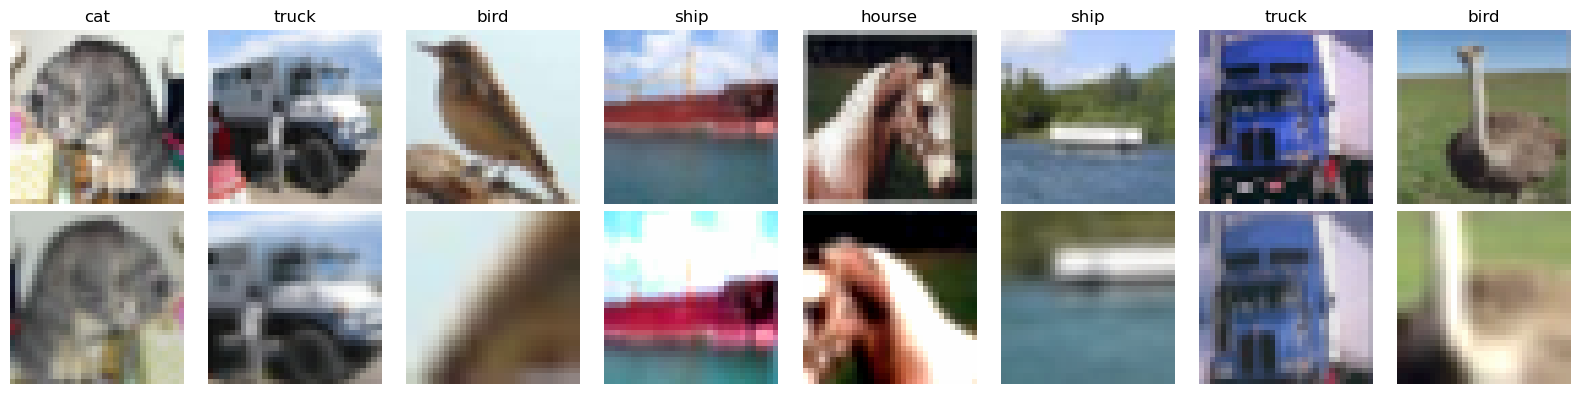

In [12]:
dataset = CIFAR10(root=data_path, train=True, download=True)
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'hourse', 'ship', 'truck'] 

total_num = 8
fig = plt.subplots(2, total_num, figsize=(total_num * 2, 4))  # Set up grid
for num in range(total_num):
    # Generate a random index
    idx = random.randint(0, len(dataset) - 1)
    
    # Fetch image and label at the random index
    img, label = dataset[idx]
    
    # Apply the transformation to the image
    original_image = img
    transformed_image = train_transform(img)
    
    # Plot the transformed image
    # Convert tensor to numpy array and rearrange dimensions
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = np.clip((transformed_image * std) + mean, 0, 1)
    #print(transformed_image)

    plt.subplot(2, total_num, num + 1)
    plt.imshow(original_image)
    plt.title(classes[label])
    plt.axis('off')
    plt.subplot(2, total_num, num + total_num + 1)
    plt.imshow(transformed_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def plot_loss(filename, hold=False):
    # Read the CSV file
    df = pd.read_csv(os.path.join(result_path, filename))

    # Extract epoch and loss columns
    epoch = df['Epoch']
    loss = df['Loss']

    # Plot the loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(epoch, loss, marker='o', linestyle='-')
    plt.title('Loss Curve for unsupervised learning')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def plot_classified_result(filename):
    # Read the CSV file
    df = pd.read_csv(os.path.join(result_path, filename))

    # Extract epoch and loss columns
    epoch = df['Epoch']
    loss = df['Loss']
    accuracy = df['Accuracy']
    tp1_acc = df['Top1 Acc']
    tp5_acc = df['Top5 Acc']

    # Plot the loss curve\
    fig = plt.subplots(2, 2, figsize=(12, 7))
    plt.suptitle('Training using 50000 (100%) samples', fontsize=16)
    plt.subplot(2, 2, 1)
    plt.plot(epoch, loss, linestyle='-')
    plt.title('Loss Curve for training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.subplot(2, 2, 2)
    plt.plot(epoch, accuracy, linestyle='-')
    plt.title('Accuracy for training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.subplot(2, 2, 3)
    plt.plot(epoch, tp1_acc, linestyle='-')
    plt.title('Top 1 Accuracy for testing dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.subplot(2, 2, 4)
    plt.plot(epoch, tp5_acc, linestyle='-')
    plt.title('Top 5 Accuracy for testing dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.show()

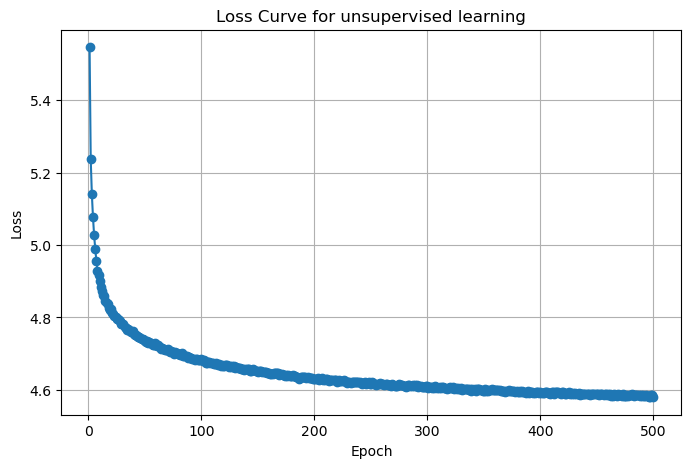

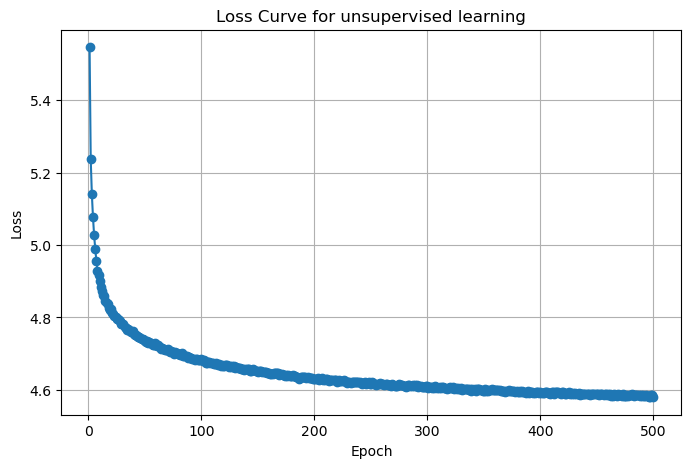

In [16]:
plot_loss('SimCLR_B256_E500.csv', hold=True)
plot_loss('SimCLR_B256_E500.csv', hold=False)

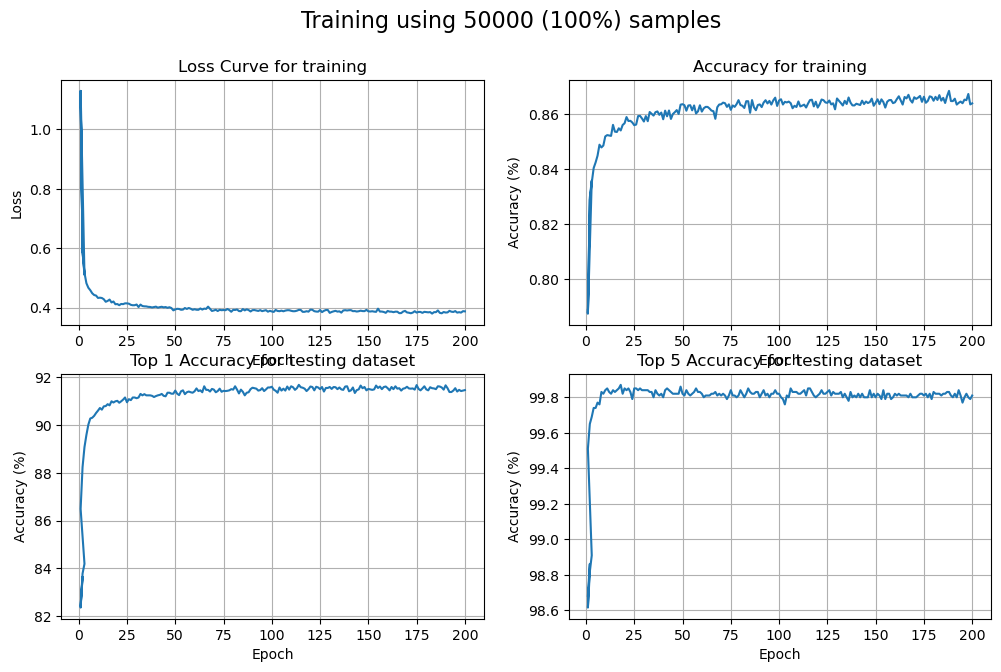

In [26]:
plot_classified_result('SimCLR_B256_E500_R1_Classifier.csv')